In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tst import Transformer


In [54]:
def create_sequences(data, input_length, output_length):
    X, y = [], []
    for i in range(len(data) - input_length - output_length):
        X.append(data[i:(i + input_length)])
        # y.append(data[(i + input_length):(i + input_length + output_length), 2])  # Extracting only the 'Close' values
        y.append(data[(i + input_length):(i + input_length + output_length),2:3])  # 2 is the index of 'Close' in input_features
        # print(y)
    X = np.array(X)
    y = np.array(y)
    return X, y

# def create_sequences(data, input_length, output_length):
#     X, y = [], []
#     for i in range(0,(len(data) - input_length - output_length + 1), output_length):
#         X.append(data[i:(i + input_length)]) # X shape should be [N,50,6]
#         y.append(data[(i + input_length):(i + input_length + output_length), 2:3]) # y shape should be [N,3,6]
#     return np.array(X), np.array(y)


# Checking if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device = ',device)

device =  cuda


In [55]:
# names_1 = 'fakedata.csv'
# pred_names = ['fakedata']
names_1 = 'ebay.csv'
#pred_names = ['gpt']


names = names_1
num_stocks = 1

csv_data = pd.read_csv(os.path.join("data", names_1))
symbol_name = names_1.split('.')[0]
print(symbol_name)
csv_data

ebay


,Date,Open,High,Low,Close,Adj close,Volume,Sentiment_gpt,News_flag,Scaled_sentiment
0,2009-10-15 00:00:00+00:00,10.627104,10.681818,10.462963,10.484007,9.656934,32784761,5.000000,1.0,1.000025
1,2009-10-16 00:00:00+00:00,10.547138,10.559764,10.239899,10.307239,9.494108,44433576,4.902459,0.0,0.975640
2,2009-10-19 00:00:00+00:00,10.408249,10.627104,10.269360,10.585017,9.749973,41054666,4.637462,0.0,0.909390
3,2009-10-20 00:00:00+00:00,10.614478,10.643939,10.404040,10.547138,9.715087,34886808,4.557602,0.0,0.889425
4,2009-10-21 00:00:00+00:00,10.711279,10.858586,10.488215,10.534512,9.703452,97286508,4.481636,0.0,0.870434
...,...,...,...,...,...,...,...,...,...,...
3562,2023-12-11 00:00:00+00:00,40.740002,42.119999,40.630001,41.759998,41.759998,7045400,2.000000,1.0,0.250025
3563,2023-12-12 00:00:00+00:00,41.770000,41.790001,40.910000,41.110001,41.110001,5839900,1.000000,1.0,0.000025
3564,2023-12-13 00:00:00+00:00,41.020000,41.980000,40.740002,41.959999,41.959999,6610400,1.097541,0.0,0.024410
3565,2023-12-14 00:00:00+00:00,42.299999,42.730000,41.990002,42.650002,42.650002,9011200,3.000000,1.0,0.500025


In [56]:

# Preparing the data for the model
# Selecting relevant columns: 'Volume', 'Open', 'Close', and 'Scaled_sentiment'
data = csv_data[['Volume', 'Open', 'Close', 'Scaled_sentiment']].values
data.shape


(3567, 4)

[1.000025   0.97563971 0.90939038 ... 0.02441029 0.500025   0.500025  ]


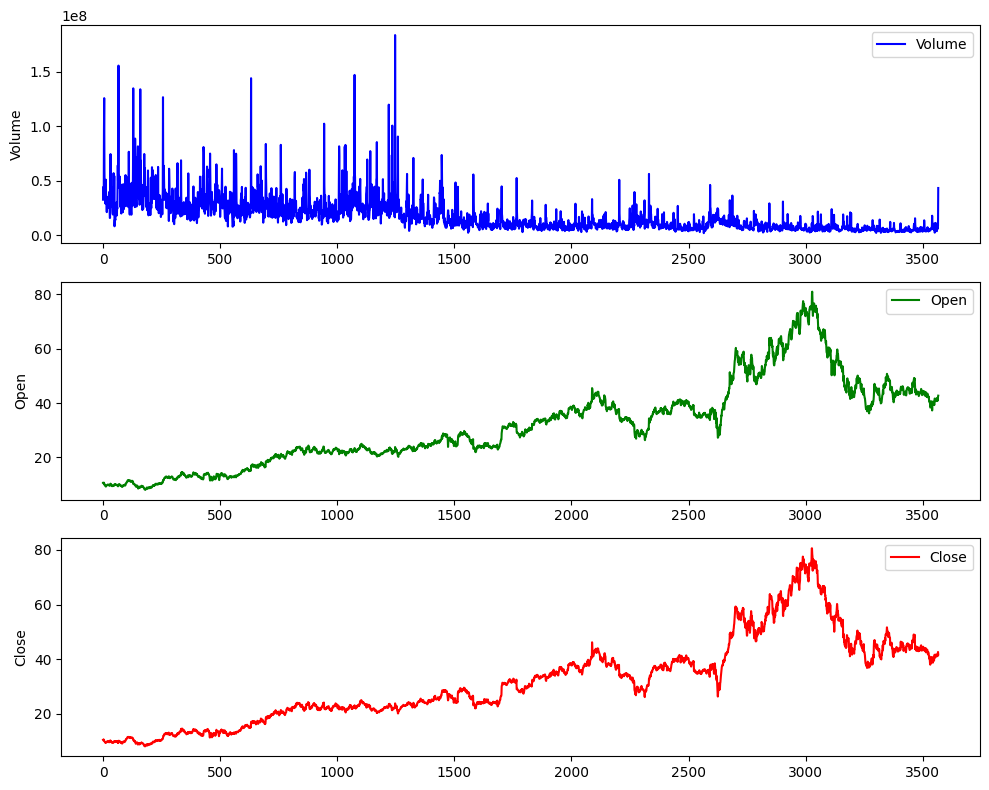

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'csv_data' is a Pandas DataFrame
data = csv_data[['Volume', 'Open', 'Close', 'Scaled_sentiment']].values

# Create a figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))

# Extract each column for plotting
volume = data[:, 0]
open_price = data[:, 1]
close_price = data[:, 2]
sentiment = data[:, 3]
print(sentiment)

# Plot 'Volume'
axes[0].plot(volume, label='Volume', color='blue')
axes[0].set_ylabel('Volume')
axes[0].legend(loc='upper right')

# Plot 'Open'
axes[1].plot(open_price, label='Open', color='green')
axes[1].set_ylabel('Open')
axes[1].legend(loc='upper right')

# Plot 'Close'
axes[2].plot(close_price, label='Close', color='red')
axes[2].set_ylabel('Close')
axes[2].legend(loc='upper right')


plt.tight_layout()
plt.show()


In [58]:
# Scaling the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Creating sequences
input_length = 50
output_length = 3
scaled_data.shape

(3567, 4)

In [59]:
scaled_data.shape

(3567, 4)

In [60]:
# Split training data into training and validation sets
split_ratio = 0.85
split = int(split_ratio * len(scaled_data))
data_train = scaled_data[:split]
data_test = scaled_data[split:]

# Splitting the dataset into training and testing sets (80-20 split)
X_train, y_train = create_sequences(data_train, input_length, output_length)
X_test, y_test = create_sequences(data_test, input_length, output_length)

# Displaying the shapes of the datasets to ensure correctness
print('X_train: ',X_train.shape, 'X_test', X_test.shape, 'y_train', y_train.shape, 'y_test',y_test.shape)


X_train:  (2978, 50, 4) X_test (483, 50, 4) y_train (2978, 3, 1) y_test (483, 3, 1)


In [61]:
# Converting data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)  # Transposing to match model's input shape
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
# print("Check")
print(X_train_tensor.shape)

torch.Size([2978, 50, 4])


In [62]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create a DataLoader for training data
batch_size = 64  # Adjust the batch size as needed
dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Transformer(
  (layers_encoding): ModuleList(
    (0-3): 4 x Encoder(
      (_selfAttention): MultiHeadAttention(
        (_W_q): Linear(in_features=32, out_features=64, bias=True)
        (_W_k): Linear(in_features=32, out_features=64, bias=True)
        (_W_v): Linear(in_features=32, out_features=64, bias=True)
        (_W_o): Linear(in_features=64, out_features=32, bias=True)
      )
      (_feedForward): PositionwiseFeedForward(
        (_linear1): Linear(in_features=32, out_features=2048, bias=True)
        (_linear2): Linear(in_features=2048, out_features=32, bias=True)
      )
      (_layerNorm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (_layerNorm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (_dopout): Dropout(p=0.1, inplace=False)
    )
  )
  (layers_decoding): ModuleList(
    (0-3): 4 x Decoder(
      (_selfAttention): MultiHeadAttention(
        (_W_q): Linear(in_features=32, out_features=64, bias=True)
        (_W_k): Linear(in_features=3

[Epoch   1/20]:  13%|██████████████▎                                                                                                | 384/2978 [00:00<00:01, 2336.11it/s, loss=0.0814]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   1/20]:  28%|███████████████████████████████                                                                                | 832/2978 [00:00<00:00, 2321.48it/s, loss=0.0626]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   1/20]:  30%|█████████████████████████████████▍                                                                             | 896/2978 [00:00<00:00, 2321.48it/s, loss=0.0614]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   1/20]:  45%|█████████████████████████████████████████████████▋                                                            | 1344/2978 [00:00<00:00, 2294.03it/s, loss=0.0558]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   1/20]:  47%|████████████████████████████████████████████████████                                                          | 1408/2978 [00:00<00:00, 2294.03it/s, loss=0.0553]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   1/20]:  62%|████████████████████████████████████████████████████████████████████▌                                         | 1856/2978 [00:00<00:00, 2261.70it/s, loss=0.0525]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   1/20]:  64%|███████████████████████████████████████████████████████████████████████▌                                       | 1920/2978 [00:00<00:00, 2261.70it/s, loss=0.052]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   1/20]:  77%|██████████████████████████████████████████████████████████████████████████████████████▋                         | 2304/2978 [00:01<00:00, 2281.49it/s, loss=0.05]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   1/20]:  82%|█████████████████████████████████████████████████████████████████████████████████████████▊                    | 2432/2978 [00:01<00:00, 2281.49it/s, loss=0.0488]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   1/20]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2816/2978 [00:01<00:00, 2185.09it/s, loss=0.048]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   1/20]:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2880/2978 [00:01<00:00, 2185.09it/s, loss=0.0472]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   1/20]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2978/2978 [00:01<00:00, 2204.87it/s, loss=0.0471]


torch.Size([34, 3]) torch.Size([34, 3])


[Epoch   2/20]:   6%|███████▏                                                                                                       | 192/2978 [00:00<00:01, 1857.79it/s, loss=0.0342]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   2/20]:  11%|███████████▉                                                                                                   | 320/2978 [00:00<00:01, 1857.79it/s, loss=0.0334]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   2/20]:  17%|███████████████████                                                                                            | 512/2978 [00:00<00:01, 2281.81it/s, loss=0.0335]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   2/20]:  19%|█████████████████████▍                                                                                         | 576/2978 [00:00<00:01, 2281.81it/s, loss=0.0324]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   2/20]:  26%|████████████████████████████▋                                                                                  | 768/2978 [00:00<00:01, 1959.32it/s, loss=0.0318]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   2/20]:  28%|███████████████████████████████                                                                                | 832/2978 [00:00<00:01, 1959.32it/s, loss=0.0316]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   2/20]:  37%|████████████████████████████████████████▏                                                                     | 1088/2978 [00:00<00:00, 2084.16it/s, loss=0.0327]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   2/20]:  43%|███████████████████████████████████████████████▎                                                              | 1280/2978 [00:00<00:00, 2062.48it/s, loss=0.0323]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   2/20]:  45%|█████████████████████████████████████████████████▋                                                            | 1344/2978 [00:00<00:00, 2062.48it/s, loss=0.0323]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   2/20]:  52%|████████████████████████████████████████████████████████▋                                                     | 1536/2978 [00:00<00:00, 2049.13it/s, loss=0.0315]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   2/20]:  54%|███████████████████████████████████████████████████████████                                                   | 1600/2978 [00:00<00:00, 2049.13it/s, loss=0.0315]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   2/20]:  60%|██████████████████████████████████████████████████████████████████▏                                           | 1792/2978 [00:00<00:00, 2029.10it/s, loss=0.0307]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   2/20]:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 1984/2978 [00:01<00:00, 2029.10it/s, loss=0.0295]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   2/20]:  69%|███████████████████████████████████████████████████████████████████████████▋                                  | 2048/2978 [00:01<00:00, 2024.27it/s, loss=0.0291]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   2/20]:  77%|█████████████████████████████████████████████████████████████████████████████████████                         | 2304/2978 [00:01<00:00, 2085.64it/s, loss=0.0283]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   2/20]:  82%|█████████████████████████████████████████████████████████████████████████████████████████▊                    | 2432/2978 [00:01<00:00, 2085.64it/s, loss=0.0277]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   2/20]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████▌               | 2560/2978 [00:01<00:00, 2039.71it/s, loss=0.0274]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   2/20]:  88%|████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2624/2978 [00:01<00:00, 2039.71it/s, loss=0.0272]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   2/20]:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2816/2978 [00:01<00:00, 2008.90it/s, loss=0.0265]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   2/20]:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2880/2978 [00:01<00:00, 2008.90it/s, loss=0.0263]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([34, 3]) torch.Size([34, 3])


[Epoch   3/20]:   2%|██▍                                                                                                             | 64/2978 [00:00<00:02, 1349.49it/s, loss=0.0157]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   3/20]:   9%|█████████▌                                                                                                     | 256/2978 [00:00<00:01, 2243.44it/s, loss=0.0142]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   3/20]:  13%|██████████████▎                                                                                                | 384/2978 [00:00<00:01, 2243.44it/s, loss=0.0131]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   3/20]:  17%|███████████████████                                                                                            | 512/2978 [00:00<00:01, 2196.20it/s, loss=0.0127]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   3/20]:  26%|████████████████████████████▋                                                                                  | 768/2978 [00:00<00:01, 2140.62it/s, loss=0.0124]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   3/20]:  26%|████████████████████████████▋                                                                                  | 768/2978 [00:00<00:01, 2140.62it/s, loss=0.0121]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   3/20]:  30%|█████████████████████████████████▋                                                                              | 896/2978 [00:00<00:00, 2140.62it/s, loss=0.012]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   3/20]:  37%|████████████████████████████████████████▏                                                                     | 1088/2978 [00:00<00:00, 1982.60it/s, loss=0.0116]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   3/20]:  43%|███████████████████████████████████████████████▎                                                              | 1280/2978 [00:00<00:00, 2131.31it/s, loss=0.0116]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   3/20]:  45%|█████████████████████████████████████████████████▋                                                            | 1344/2978 [00:00<00:00, 2131.31it/s, loss=0.0113]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   3/20]:  52%|████████████████████████████████████████████████████████▋                                                     | 1536/2978 [00:00<00:00, 1997.10it/s, loss=0.0109]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   3/20]:  56%|█████████████████████████████████████████████████████████████▍                                                | 1664/2978 [00:00<00:00, 1997.10it/s, loss=0.0107]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   3/20]:  60%|██████████████████████████████████████████████████████████████████▏                                           | 1792/2978 [00:00<00:00, 1984.01it/s, loss=0.0105]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   3/20]:  64%|██████████████████████████████████████████████████████████████████████▉                                       | 1920/2978 [00:00<00:00, 1984.01it/s, loss=0.0102]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   3/20]:  71%|██████████████████████████████████████████████████████████████████████████████                                | 2112/2978 [00:01<00:00, 2000.59it/s, loss=0.0101]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   3/20]:  77%|█████████████████████████████████████████████████████████████████████████████████████                         | 2304/2978 [00:01<00:00, 2033.23it/s, loss=0.0099]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   3/20]:  80%|██████████████████████████████████████████████████████████████████████████████████████▋                      | 2368/2978 [00:01<00:00, 2033.23it/s, loss=0.00986]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   3/20]:  86%|██████████████████████████████████████████████████████████████████████████████████████████████▌               | 2560/2978 [00:01<00:00, 1934.04it/s, loss=0.0097]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   3/20]:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2688/2978 [00:01<00:00, 1934.04it/s, loss=0.00951]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   3/20]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████      | 2816/2978 [00:01<00:00, 1970.63it/s, loss=0.00946]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   3/20]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2978/2978 [00:01<00:00, 1992.03it/s, loss=0.00935]


torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([34, 3]) torch.Size([34, 3])


[Epoch   4/20]:   4%|████▋                                                                                                         | 128/2978 [00:00<00:01, 1565.10it/s, loss=0.00821]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   4/20]:  11%|███████████▉                                                                                                   | 320/2978 [00:00<00:01, 2421.75it/s, loss=0.0071]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   4/20]:  19%|█████████████████████▎                                                                                        | 576/2978 [00:00<00:00, 2624.95it/s, loss=0.00732]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   4/20]:  24%|██████████████████████████                                                                                    | 704/2978 [00:00<00:00, 2624.95it/s, loss=0.00733]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   4/20]:  30%|█████████████████████████████████▍                                                                             | 896/2978 [00:00<00:00, 2683.06it/s, loss=0.0071]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   4/20]:  37%|████████████████████████████████████████▌                                                                      | 1088/2978 [00:00<00:00, 2683.06it/s, loss=0.007]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   4/20]:  41%|████████████████████████████████████████████▌                                                                | 1216/2978 [00:00<00:00, 2710.07it/s, loss=0.00689]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   4/20]:  47%|███████████████████████████████████████████████████▌                                                         | 1408/2978 [00:00<00:00, 2710.07it/s, loss=0.00679]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   4/20]:  52%|████████████████████████████████████████████████████████▏                                                    | 1536/2978 [00:00<00:00, 2600.40it/s, loss=0.00679]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   4/20]:  58%|███████████████████████████████████████████████████████████████▏                                             | 1728/2978 [00:00<00:00, 2600.40it/s, loss=0.00678]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   4/20]:  64%|██████████████████████████████████████████████████████████████████████▎                                      | 1920/2978 [00:00<00:00, 2420.26it/s, loss=0.00683]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   4/20]:  71%|█████████████████████████████████████████████████████████████████████████████▎                               | 2112/2978 [00:00<00:00, 2441.10it/s, loss=0.00675]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   4/20]:  77%|████████████████████████████████████████████████████████████████████████████████████▎                        | 2304/2978 [00:00<00:00, 2441.10it/s, loss=0.00664]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   4/20]:  84%|███████████████████████████████████████████████████████████████████████████████████████████▎                 | 2496/2978 [00:01<00:00, 2486.90it/s, loss=0.00662]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   4/20]:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2688/2978 [00:01<00:00, 2455.69it/s, loss=0.00657]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   4/20]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████      | 2816/2978 [00:01<00:00, 2455.69it/s, loss=0.00651]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   4/20]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2978/2978 [00:01<00:00, 2508.33it/s, loss=0.00649]


torch.Size([34, 3]) torch.Size([34, 3])


[Epoch   5/20]:   0%|                                                                                                                          | 0/2978 [00:00<?, ?it/s, loss=0.00643]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   5/20]:   4%|████▋                                                                                                         | 128/2978 [00:00<00:01, 1460.75it/s, loss=0.00634]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   5/20]:  11%|███████████▊                                                                                                  | 320/2978 [00:00<00:01, 2298.36it/s, loss=0.00605]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   5/20]:  13%|██████████████▏                                                                                               | 384/2978 [00:00<00:01, 2298.36it/s, loss=0.00612]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   5/20]:  17%|██████████████████▉                                                                                           | 512/2978 [00:00<00:01, 2325.36it/s, loss=0.00619]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   5/20]:  26%|████████████████████████████▎                                                                                 | 768/2978 [00:00<00:01, 2179.90it/s, loss=0.00625]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   5/20]:  30%|█████████████████████████████████                                                                             | 896/2978 [00:00<00:00, 2179.90it/s, loss=0.00618]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   5/20]:  34%|█████████████████████████████████████▍                                                                       | 1024/2978 [00:00<00:00, 2142.52it/s, loss=0.00615]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   5/20]:  43%|███████████████████████████████████████████████▎                                                              | 1280/2978 [00:00<00:00, 2156.32it/s, loss=0.0061]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   5/20]:  45%|█████████████████████████████████████████████████▏                                                           | 1344/2978 [00:00<00:00, 2156.32it/s, loss=0.00613]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   5/20]:  52%|████████████████████████████████████████████████████████▏                                                    | 1536/2978 [00:00<00:00, 2148.41it/s, loss=0.00614]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   5/20]:  60%|█████████████████████████████████████████████████████████████████▌                                           | 1792/2978 [00:00<00:00, 2180.77it/s, loss=0.00613]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   5/20]:  60%|█████████████████████████████████████████████████████████████████▌                                           | 1792/2978 [00:00<00:00, 2180.77it/s, loss=0.00612]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   5/20]:  64%|██████████████████████████████████████████████████████████████████████▎                                      | 1920/2978 [00:00<00:00, 2180.77it/s, loss=0.00601]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   5/20]:  73%|████████████████████████████████████████████████████████████████████████████████▍                             | 2176/2978 [00:01<00:00, 2216.71it/s, loss=0.0059]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   5/20]:  77%|████████████████████████████████████████████████████████████████████████████████████▎                        | 2304/2978 [00:01<00:00, 2227.26it/s, loss=0.00586]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   5/20]:  82%|█████████████████████████████████████████████████████████████████████████████████████████                    | 2432/2978 [00:01<00:00, 2227.26it/s, loss=0.00589]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   5/20]:  88%|████████████████████████████████████████████████████████████████████████████████████████████████             | 2624/2978 [00:01<00:00, 2147.14it/s, loss=0.00586]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   5/20]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████      | 2816/2978 [00:01<00:00, 2154.71it/s, loss=0.00584]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   5/20]:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2880/2978 [00:01<00:00, 2154.71it/s, loss=0.00583]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   5/20]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2978/2978 [00:01<00:00, 2157.76it/s, loss=0.00589]


torch.Size([34, 3]) torch.Size([34, 3])


[Epoch   6/20]:   4%|████▋                                                                                                         | 128/2978 [00:00<00:01, 1757.01it/s, loss=0.00456]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   6/20]:   9%|█████████▌                                                                                                     | 256/2978 [00:00<00:01, 2359.29it/s, loss=0.0046]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   6/20]:  11%|███████████▊                                                                                                  | 320/2978 [00:00<00:01, 2359.29it/s, loss=0.00473]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   6/20]:  13%|██████████████▏                                                                                               | 384/2978 [00:00<00:01, 2359.29it/s, loss=0.00472]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   6/20]:  21%|███████████████████████▋                                                                                      | 640/2978 [00:00<00:01, 2125.20it/s, loss=0.00506]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   6/20]:  26%|████████████████████████████▎                                                                                 | 768/2978 [00:00<00:01, 2117.31it/s, loss=0.00513]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   6/20]:  34%|█████████████████████████████████████▍                                                                       | 1024/2978 [00:00<00:00, 2089.25it/s, loss=0.00536]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   6/20]:  43%|██████████████████████████████████████████████▊                                                              | 1280/2978 [00:00<00:00, 2145.41it/s, loss=0.00532]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   6/20]:  43%|██████████████████████████████████████████████▊                                                              | 1280/2978 [00:00<00:00, 2145.41it/s, loss=0.00535]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   6/20]:  52%|████████████████████████████████████████████████████████▏                                                    | 1536/2978 [00:00<00:00, 2155.52it/s, loss=0.00531]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   6/20]:  56%|████████████████████████████████████████████████████████████▉                                                | 1664/2978 [00:00<00:00, 2155.52it/s, loss=0.00526]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   6/20]:  60%|█████████████████████████████████████████████████████████████████▌                                           | 1792/2978 [00:00<00:00, 2195.93it/s, loss=0.00532]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   6/20]:  69%|██████████████████████████████████████████████████████████████████████████▉                                  | 2048/2978 [00:00<00:00, 2179.66it/s, loss=0.00531]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   6/20]:  71%|█████████████████████████████████████████████████████████████████████████████▎                               | 2112/2978 [00:01<00:00, 2179.66it/s, loss=0.00531]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   6/20]:  77%|████████████████████████████████████████████████████████████████████████████████████▎                        | 2304/2978 [00:01<00:00, 2171.69it/s, loss=0.00526]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   6/20]:  86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 2560/2978 [00:01<00:00, 2217.27it/s, loss=0.00527]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   6/20]:  86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 2560/2978 [00:01<00:00, 2217.27it/s, loss=0.00529]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   6/20]:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2688/2978 [00:01<00:00, 2217.27it/s, loss=0.00525]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   6/20]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2978/2978 [00:01<00:00, 2135.94it/s, loss=0.0053]


torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([34, 3]) torch.Size([34, 3])


[Epoch   7/20]:   0%|                                                                                                                                        | 0/2978 [00:00<?, ?it/s]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   7/20]:   2%|██▍                                                                                                             | 64/2978 [00:00<00:02, 1286.00it/s, loss=0.0047]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   7/20]:   4%|████▋                                                                                                         | 128/2978 [00:00<00:01, 1723.64it/s, loss=0.00486]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   7/20]:  15%|████████████████▌                                                                                             | 448/2978 [00:00<00:00, 2533.78it/s, loss=0.00528]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   7/20]:  19%|█████████████████████▎                                                                                        | 576/2978 [00:00<00:00, 2490.72it/s, loss=0.00523]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   7/20]:  19%|█████████████████████▎                                                                                        | 576/2978 [00:00<00:00, 2490.72it/s, loss=0.00524]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   7/20]:  21%|███████████████████████▊                                                                                       | 640/2978 [00:00<00:00, 2490.72it/s, loss=0.0051]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   7/20]:  30%|█████████████████████████████████                                                                             | 896/2978 [00:00<00:00, 2279.27it/s, loss=0.00508]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   7/20]:  32%|███████████████████████████████████▍                                                                          | 960/2978 [00:00<00:00, 2279.27it/s, loss=0.00509]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   7/20]:  37%|███████████████████████████████████████▊                                                                     | 1088/2978 [00:00<00:00, 2201.09it/s, loss=0.00507]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   7/20]:  37%|███████████████████████████████████████▊                                                                     | 1088/2978 [00:00<00:00, 2201.09it/s, loss=0.00506]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   7/20]:  45%|█████████████████████████████████████████████████▏                                                           | 1344/2978 [00:00<00:00, 2208.14it/s, loss=0.00499]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   7/20]:  47%|███████████████████████████████████████████████████▌                                                         | 1408/2978 [00:00<00:00, 2208.14it/s, loss=0.00499]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   7/20]:  52%|████████████████████████████████████████████████████████▏                                                    | 1536/2978 [00:00<00:00, 2208.14it/s, loss=0.00502]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   7/20]:  60%|█████████████████████████████████████████████████████████████████▌                                           | 1792/2978 [00:00<00:00, 2249.65it/s, loss=0.00505]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   7/20]:  64%|██████████████████████████████████████████████████████████████████████▎                                      | 1920/2978 [00:00<00:00, 2112.94it/s, loss=0.00499]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   7/20]:  67%|████████████████████████████████████████████████████████████████████████▌                                    | 1984/2978 [00:00<00:00, 2112.94it/s, loss=0.00501]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   7/20]:  77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 2304/2978 [00:01<00:00, 2126.72it/s, loss=0.005]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   7/20]:  82%|█████████████████████████████████████████████████████████████████████████████████████████                    | 2432/2978 [00:01<00:00, 2118.69it/s, loss=0.00497]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   7/20]:  84%|███████████████████████████████████████████████████████████████████████████████████████████▎                 | 2496/2978 [00:01<00:00, 2118.69it/s, loss=0.00497]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   7/20]:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2752/2978 [00:01<00:00, 2090.32it/s, loss=0.00498]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   7/20]:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2944/2978 [00:01<00:00, 2035.49it/s, loss=0.00498]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([34, 3]) torch.Size([34, 3])


[Epoch   8/20]:   6%|███████                                                                                                       | 192/2978 [00:00<00:01, 1609.61it/s, loss=0.00476]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   8/20]:   6%|███████                                                                                                       | 192/2978 [00:00<00:01, 1609.61it/s, loss=0.00492]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   8/20]:  15%|████████████████▌                                                                                             | 448/2978 [00:00<00:01, 2119.47it/s, loss=0.00513]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   8/20]:  19%|█████████████████████▎                                                                                        | 576/2978 [00:00<00:01, 2119.47it/s, loss=0.00487]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   8/20]:  24%|██████████████████████████▏                                                                                    | 704/2978 [00:00<00:01, 2147.61it/s, loss=0.0048]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   8/20]:  32%|███████████████████████████████████▍                                                                          | 960/2978 [00:00<00:00, 2180.06it/s, loss=0.00488]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   8/20]:  37%|███████████████████████████████████████▊                                                                     | 1088/2978 [00:00<00:00, 2180.06it/s, loss=0.00479]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   8/20]:  45%|█████████████████████████████████████████████████▏                                                           | 1344/2978 [00:00<00:00, 2195.45it/s, loss=0.00466]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   8/20]:  54%|███████████████████████████████████████████████████████████                                                   | 1600/2978 [00:00<00:00, 2133.00it/s, loss=0.0048]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   8/20]:  60%|█████████████████████████████████████████████████████████████████▌                                           | 1792/2978 [00:00<00:00, 2159.97it/s, loss=0.00471]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   8/20]:  69%|██████████████████████████████████████████████████████████████████████████▉                                  | 2048/2978 [00:00<00:00, 2157.41it/s, loss=0.00468]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   8/20]:  75%|█████████████████████████████████████████████████████████████████████████████████▉                           | 2240/2978 [00:01<00:00, 2176.26it/s, loss=0.00463]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   8/20]:  84%|███████████████████████████████████████████████████████████████████████████████████████████▎                 | 2496/2978 [00:01<00:00, 2192.61it/s, loss=0.00464]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   8/20]:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2752/2978 [00:01<00:00, 2183.61it/s, loss=0.00464]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   8/20]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2978/2978 [00:01<00:00, 2137.63it/s, loss=0.00465]


torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([34, 3]) torch.Size([34, 3])


[Epoch   9/20]:   4%|████▋                                                                                                         | 128/2978 [00:00<00:01, 1493.68it/s, loss=0.00508]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   9/20]:  13%|██████████████▏                                                                                               | 384/2978 [00:00<00:01, 2223.75it/s, loss=0.00495]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   9/20]:  19%|█████████████████████▎                                                                                        | 576/2978 [00:00<00:01, 2186.56it/s, loss=0.00479]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   9/20]:  28%|██████████████████████████████▋                                                                               | 832/2978 [00:00<00:00, 2239.89it/s, loss=0.00483]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   9/20]:  37%|███████████████████████████████████████▊                                                                     | 1088/2978 [00:00<00:00, 2281.67it/s, loss=0.00466]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   9/20]:  47%|███████████████████████████████████████████████████▌                                                         | 1408/2978 [00:00<00:00, 2331.16it/s, loss=0.00461]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   9/20]:  56%|████████████████████████████████████████████████████████████▉                                                | 1664/2978 [00:00<00:00, 2490.13it/s, loss=0.00461]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   9/20]:  62%|███████████████████████████████████████████████████████████████████▉                                         | 1856/2978 [00:00<00:00, 2270.17it/s, loss=0.00462]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   9/20]:  71%|█████████████████████████████████████████████████████████████████████████████▎                               | 2112/2978 [00:00<00:00, 2195.47it/s, loss=0.00459]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   9/20]:  80%|██████████████████████████████████████████████████████████████████████████████████████▋                      | 2368/2978 [00:01<00:00, 2160.73it/s, loss=0.00458]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   9/20]:  88%|████████████████████████████████████████████████████████████████████████████████████████████████             | 2624/2978 [00:01<00:00, 2128.11it/s, loss=0.00455]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   9/20]:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2880/2978 [00:01<00:00, 2197.74it/s, loss=0.00451]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch   9/20]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2978/2978 [00:01<00:00, 2224.69it/s, loss=0.00451]


torch.Size([34, 3]) torch.Size([34, 3])


[Epoch  10/20]:   0%|                                                                                                                          | 0/2978 [00:00<?, ?it/s, loss=0.00458]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  10/20]:  13%|██████████████▏                                                                                               | 384/2978 [00:00<00:01, 2351.49it/s, loss=0.00391]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  10/20]:  19%|█████████████████████▎                                                                                        | 576/2978 [00:00<00:00, 2605.53it/s, loss=0.00414]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  10/20]:  21%|███████████████████████▋                                                                                      | 640/2978 [00:00<00:00, 2605.53it/s, loss=0.00406]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  10/20]:  32%|███████████████████████████████████▍                                                                          | 960/2978 [00:00<00:00, 2687.25it/s, loss=0.00419]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  10/20]:  37%|███████████████████████████████████████▊                                                                     | 1088/2978 [00:00<00:00, 2687.25it/s, loss=0.00425]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  10/20]:  41%|████████████████████████████████████████████▌                                                                | 1216/2978 [00:00<00:00, 2723.33it/s, loss=0.00419]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  10/20]:  52%|████████████████████████████████████████████████████████▋                                                     | 1536/2978 [00:00<00:00, 2736.95it/s, loss=0.0042]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  10/20]:  56%|████████████████████████████████████████████████████████████▉                                                | 1664/2978 [00:00<00:00, 2736.95it/s, loss=0.00426]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  10/20]:  62%|████████████████████████████████████████████████████████████████████▌                                         | 1856/2978 [00:00<00:00, 2748.92it/s, loss=0.0043]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  10/20]:  73%|███████████████████████████████████████████████████████████████████████████████▋                             | 2176/2978 [00:00<00:00, 2758.91it/s, loss=0.00437]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  10/20]:  75%|█████████████████████████████████████████████████████████████████████████████████▉                           | 2240/2978 [00:00<00:00, 2758.91it/s, loss=0.00438]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  10/20]:  77%|████████████████████████████████████████████████████████████████████████████████████▎                        | 2304/2978 [00:00<00:00, 2758.91it/s, loss=0.00442]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  10/20]:  88%|████████████████████████████████████████████████████████████████████████████████████████████████             | 2624/2978 [00:01<00:00, 2673.71it/s, loss=0.00445]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  10/20]:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2688/2978 [00:01<00:00, 2673.71it/s, loss=0.00444]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  10/20]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████      | 2816/2978 [00:01<00:00, 2513.40it/s, loss=0.00441]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  10/20]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2978/2978 [00:01<00:00, 2563.15it/s, loss=0.00434]


torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([34, 3]) torch.Size([34, 3])


[Epoch  11/20]:   2%|██▍                                                                                                            | 64/2978 [00:00<00:02, 1183.56it/s, loss=0.00361]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  11/20]:   4%|████▋                                                                                                         | 128/2978 [00:00<00:02, 1328.85it/s, loss=0.00364]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  11/20]:   9%|█████████▍                                                                                                    | 256/2978 [00:00<00:01, 2130.65it/s, loss=0.00392]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  11/20]:  13%|██████████████▏                                                                                               | 384/2978 [00:00<00:01, 2130.65it/s, loss=0.00377]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  11/20]:  17%|██████████████████▉                                                                                           | 512/2978 [00:00<00:01, 2141.37it/s, loss=0.00398]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  11/20]:  19%|█████████████████████▎                                                                                        | 576/2978 [00:00<00:01, 2141.37it/s, loss=0.00408]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  11/20]:  26%|████████████████████████████▎                                                                                 | 768/2978 [00:00<00:01, 2191.03it/s, loss=0.00394]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  11/20]:  28%|██████████████████████████████▋                                                                               | 832/2978 [00:00<00:00, 2191.03it/s, loss=0.00396]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  11/20]:  34%|█████████████████████████████████████▍                                                                       | 1024/2978 [00:00<00:00, 2168.65it/s, loss=0.00396]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  11/20]:  39%|██████████████████████████████████████████▏                                                                  | 1152/2978 [00:00<00:00, 2168.65it/s, loss=0.00401]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  11/20]:  43%|██████████████████████████████████████████████▊                                                              | 1280/2978 [00:00<00:00, 2050.76it/s, loss=0.00409]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  11/20]:  47%|███████████████████████████████████████████████████▌                                                         | 1408/2978 [00:00<00:00, 2050.76it/s, loss=0.00416]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  11/20]:  52%|████████████████████████████████████████████████████████▏                                                    | 1536/2978 [00:00<00:00, 2079.17it/s, loss=0.00417]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  11/20]:  54%|██████████████████████████████████████████████████████████▌                                                  | 1600/2978 [00:00<00:00, 2079.17it/s, loss=0.00414]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  11/20]:  60%|█████████████████████████████████████████████████████████████████▌                                           | 1792/2978 [00:00<00:00, 2128.18it/s, loss=0.00418]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  11/20]:  62%|███████████████████████████████████████████████████████████████████▉                                         | 1856/2978 [00:00<00:00, 2128.18it/s, loss=0.00416]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  11/20]:  64%|██████████████████████████████████████████████████████████████████████▎                                      | 1920/2978 [00:00<00:00, 2128.18it/s, loss=0.00417]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  11/20]:  69%|██████████████████████████████████████████████████████████████████████████▉                                  | 2048/2978 [00:01<00:00, 2097.21it/s, loss=0.00415]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  11/20]:  73%|███████████████████████████████████████████████████████████████████████████████▋                             | 2176/2978 [00:01<00:00, 2097.21it/s, loss=0.00417]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  11/20]:  77%|████████████████████████████████████████████████████████████████████████████████████▎                        | 2304/2978 [00:01<00:00, 1943.92it/s, loss=0.00417]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  11/20]:  77%|████████████████████████████████████████████████████████████████████████████████████▎                        | 2304/2978 [00:01<00:00, 1943.92it/s, loss=0.00417]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  11/20]:  82%|█████████████████████████████████████████████████████████████████████████████████████████                    | 2432/2978 [00:01<00:00, 1943.92it/s, loss=0.00417]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  11/20]:  88%|████████████████████████████████████████████████████████████████████████████████████████████████             | 2624/2978 [00:01<00:00, 1958.00it/s, loss=0.00412]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  11/20]:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2688/2978 [00:01<00:00, 1958.00it/s, loss=0.00412]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  11/20]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████      | 2816/2978 [00:01<00:00, 2016.50it/s, loss=0.00412]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  11/20]:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2880/2978 [00:01<00:00, 2016.50it/s, loss=0.00413]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  11/20]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2978/2978 [00:01<00:00, 2033.44it/s, loss=0.00412]


torch.Size([34, 3]) torch.Size([34, 3])


[Epoch  12/20]:   2%|██▍                                                                                                            | 64/2978 [00:00<00:02, 1237.16it/s, loss=0.00413]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  12/20]:   4%|████▋                                                                                                         | 128/2978 [00:00<00:01, 1537.68it/s, loss=0.00397]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  12/20]:   9%|█████████▍                                                                                                    | 256/2978 [00:00<00:01, 2201.73it/s, loss=0.00439]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  12/20]:  11%|███████████▊                                                                                                  | 320/2978 [00:00<00:01, 2201.73it/s, loss=0.00443]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  12/20]:  17%|██████████████████▉                                                                                           | 512/2978 [00:00<00:01, 1846.42it/s, loss=0.00429]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  12/20]:  17%|██████████████████▉                                                                                           | 512/2978 [00:00<00:01, 1846.42it/s, loss=0.00428]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  12/20]:  19%|█████████████████████▎                                                                                        | 576/2978 [00:00<00:01, 1846.42it/s, loss=0.00421]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  12/20]:  26%|████████████████████████████▎                                                                                 | 768/2978 [00:00<00:01, 1811.76it/s, loss=0.00426]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  12/20]:  26%|████████████████████████████▋                                                                                  | 768/2978 [00:00<00:01, 1811.76it/s, loss=0.0042]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  12/20]:  30%|█████████████████████████████████                                                                             | 896/2978 [00:00<00:01, 1811.76it/s, loss=0.00428]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  12/20]:  39%|██████████████████████████████████████████▏                                                                  | 1152/2978 [00:00<00:00, 1859.00it/s, loss=0.00434]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  12/20]:  43%|██████████████████████████████████████████████▊                                                              | 1280/2978 [00:00<00:00, 1956.95it/s, loss=0.00431]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  12/20]:  45%|█████████████████████████████████████████████████▏                                                           | 1344/2978 [00:00<00:00, 1956.95it/s, loss=0.00425]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  12/20]:  54%|██████████████████████████████████████████████████████████▌                                                  | 1600/2978 [00:00<00:00, 2090.37it/s, loss=0.00416]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  12/20]:  60%|█████████████████████████████████████████████████████████████████▌                                           | 1792/2978 [00:00<00:00, 2042.27it/s, loss=0.00412]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  12/20]:  60%|█████████████████████████████████████████████████████████████████▌                                           | 1792/2978 [00:00<00:00, 2042.27it/s, loss=0.00413]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  12/20]:  69%|██████████████████████████████████████████████████████████████████████████▉                                  | 2048/2978 [00:01<00:00, 2035.08it/s, loss=0.00412]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  12/20]:  73%|████████████████████████████████████████████████████████████████████████████████▍                             | 2176/2978 [00:01<00:00, 2035.08it/s, loss=0.0041]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  12/20]:  77%|████████████████████████████████████████████████████████████████████████████████████▎                        | 2304/2978 [00:01<00:00, 2057.87it/s, loss=0.00407]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  12/20]:  86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 2560/2978 [00:01<00:00, 2097.31it/s, loss=0.00409]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  12/20]:  86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 2560/2978 [00:01<00:00, 2097.31it/s, loss=0.00409]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  12/20]:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2688/2978 [00:01<00:00, 2097.31it/s, loss=0.00404]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  12/20]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2978/2978 [00:01<00:00, 2003.19it/s, loss=0.00397]


torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([34, 3]) torch.Size([34, 3])


[Epoch  13/20]:   0%|                                                                                                                                        | 0/2978 [00:00<?, ?it/s]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  13/20]:   4%|████▋                                                                                                         | 128/2978 [00:00<00:01, 1852.48it/s, loss=0.00392]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  13/20]:  11%|███████████▊                                                                                                  | 320/2978 [00:00<00:00, 2769.19it/s, loss=0.00399]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  13/20]:  15%|████████████████▌                                                                                             | 448/2978 [00:00<00:00, 2769.19it/s, loss=0.00405]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  13/20]:  17%|██████████████████▉                                                                                           | 512/2978 [00:00<00:00, 2769.19it/s, loss=0.00411]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  13/20]:  21%|████████████████████████                                                                                        | 640/2978 [00:00<00:00, 2555.02it/s, loss=0.004]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  13/20]:  26%|████████████████████████████▎                                                                                 | 768/2978 [00:00<00:00, 2555.02it/s, loss=0.00411]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  13/20]:  32%|███████████████████████████████████▍                                                                          | 960/2978 [00:00<00:00, 2295.78it/s, loss=0.00401]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  13/20]:  34%|█████████████████████████████████████▍                                                                       | 1024/2978 [00:00<00:00, 2295.78it/s, loss=0.00392]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  13/20]:  37%|███████████████████████████████████████▊                                                                     | 1088/2978 [00:00<00:00, 2295.78it/s, loss=0.00387]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  13/20]:  41%|████████████████████████████████████████████▌                                                                | 1216/2978 [00:00<00:00, 2330.63it/s, loss=0.00388]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  13/20]:  49%|█████████████████████████████████████████████████████▉                                                       | 1472/2978 [00:00<00:00, 2174.35it/s, loss=0.00394]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  13/20]:  49%|█████████████████████████████████████████████████████▉                                                       | 1472/2978 [00:00<00:00, 2174.35it/s, loss=0.00395]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  13/20]:  54%|██████████████████████████████████████████████████████████▌                                                  | 1600/2978 [00:00<00:00, 2174.35it/s, loss=0.00399]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  13/20]:  58%|███████████████████████████████████████████████████████████████▏                                             | 1728/2978 [00:00<00:00, 2199.96it/s, loss=0.00397]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  13/20]:  62%|███████████████████████████████████████████████████████████████████▉                                         | 1856/2978 [00:00<00:00, 2199.96it/s, loss=0.00398]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  13/20]:  67%|████████████████████████████████████████████████████████████████████████▌                                    | 1984/2978 [00:00<00:00, 2202.74it/s, loss=0.00399]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  13/20]:  71%|█████████████████████████████████████████████████████████████████████████████▎                               | 2112/2978 [00:00<00:00, 2202.74it/s, loss=0.00396]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  13/20]:  75%|█████████████████████████████████████████████████████████████████████████████████▉                           | 2240/2978 [00:01<00:00, 2140.60it/s, loss=0.00395]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  13/20]:  77%|████████████████████████████████████████████████████████████████████████████████████▎                        | 2304/2978 [00:01<00:00, 2140.60it/s, loss=0.00394]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  13/20]:  86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 2560/2978 [00:01<00:00, 2100.46it/s, loss=0.00396]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  13/20]:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2752/2978 [00:01<00:00, 2100.04it/s, loss=0.00393]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  13/20]:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2752/2978 [00:01<00:00, 2100.04it/s, loss=0.00393]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  13/20]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████      | 2816/2978 [00:01<00:00, 2100.04it/s, loss=0.00392]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  13/20]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2978/2978 [00:01<00:00, 2022.75it/s, loss=0.00387]


torch.Size([34, 3]) torch.Size([34, 3])


[Epoch  14/20]:   0%|                                                                                                                          | 0/2978 [00:00<?, ?it/s, loss=0.00279]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  14/20]:   9%|█████████▍                                                                                                    | 256/2978 [00:00<00:01, 1617.15it/s, loss=0.00369]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  14/20]:  17%|██████████████████▉                                                                                           | 512/2978 [00:00<00:01, 2184.02it/s, loss=0.00379]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  14/20]:  17%|██████████████████▉                                                                                           | 512/2978 [00:00<00:01, 2184.02it/s, loss=0.00373]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  14/20]:  26%|████████████████████████████▎                                                                                 | 768/2978 [00:00<00:01, 2186.30it/s, loss=0.00377]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  14/20]:  30%|█████████████████████████████████                                                                             | 896/2978 [00:00<00:00, 2186.30it/s, loss=0.00376]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  14/20]:  34%|█████████████████████████████████████▍                                                                       | 1024/2978 [00:00<00:00, 2292.35it/s, loss=0.00372]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  14/20]:  43%|██████████████████████████████████████████████▊                                                              | 1280/2978 [00:00<00:00, 2226.09it/s, loss=0.00368]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  14/20]:  47%|███████████████████████████████████████████████████▌                                                         | 1408/2978 [00:00<00:00, 2226.09it/s, loss=0.00373]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  14/20]:  52%|████████████████████████████████████████████████████████▏                                                    | 1536/2978 [00:00<00:00, 2265.10it/s, loss=0.00372]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  14/20]:  56%|████████████████████████████████████████████████████████████▉                                                | 1664/2978 [00:00<00:00, 2265.10it/s, loss=0.00374]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  14/20]:  60%|█████████████████████████████████████████████████████████████████▌                                           | 1792/2978 [00:00<00:00, 1879.81it/s, loss=0.00374]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  14/20]:  60%|█████████████████████████████████████████████████████████████████▌                                           | 1792/2978 [00:00<00:00, 1879.81it/s, loss=0.00377]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  14/20]:  69%|██████████████████████████████████████████████████████████████████████████▉                                  | 2048/2978 [00:01<00:00, 1828.11it/s, loss=0.00374]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  14/20]:  73%|███████████████████████████████████████████████████████████████████████████████▋                             | 2176/2978 [00:01<00:00, 1828.11it/s, loss=0.00376]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  14/20]:  77%|████████████████████████████████████████████████████████████████████████████████████▎                        | 2304/2978 [00:01<00:00, 1886.01it/s, loss=0.00376]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  14/20]:  86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 2560/2978 [00:01<00:00, 2040.10it/s, loss=0.00372]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  14/20]:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2688/2978 [00:01<00:00, 2040.10it/s, loss=0.00374]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  14/20]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████      | 2816/2978 [00:01<00:00, 2124.92it/s, loss=0.00373]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  14/20]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2978/2978 [00:01<00:00, 2054.50it/s, loss=0.00372]


torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([34, 3]) torch.Size([34, 3])


[Epoch  15/20]:   0%|                                                                                                                                        | 0/2978 [00:00<?, ?it/s]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  15/20]:   2%|██▍                                                                                                             | 64/2978 [00:00<00:04, 656.82it/s, loss=0.00334]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  15/20]:   6%|███████                                                                                                       | 192/2978 [00:00<00:02, 1260.00it/s, loss=0.00346]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  15/20]:   6%|███████                                                                                                       | 192/2978 [00:00<00:02, 1260.00it/s, loss=0.00353]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  15/20]:  11%|███████████▊                                                                                                  | 320/2978 [00:00<00:02, 1201.31it/s, loss=0.00355]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  15/20]:  15%|████████████████▌                                                                                             | 448/2978 [00:00<00:02, 1201.31it/s, loss=0.00372]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  15/20]:  21%|███████████████████████▋                                                                                      | 640/2978 [00:00<00:01, 1864.60it/s, loss=0.00374]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  15/20]:  26%|████████████████████████████▎                                                                                 | 768/2978 [00:00<00:01, 1864.60it/s, loss=0.00367]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  15/20]:  32%|███████████████████████████████████▍                                                                          | 960/2978 [00:00<00:00, 2195.28it/s, loss=0.00367]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  15/20]:  34%|█████████████████████████████████████▍                                                                       | 1024/2978 [00:00<00:00, 2195.28it/s, loss=0.00366]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  15/20]:  41%|████████████████████████████████████████████▌                                                                | 1216/2978 [00:00<00:00, 2279.74it/s, loss=0.00371]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  15/20]:  41%|████████████████████████████████████████████▌                                                                | 1216/2978 [00:00<00:00, 2279.74it/s, loss=0.00366]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  15/20]:  45%|█████████████████████████████████████████████████▏                                                           | 1344/2978 [00:00<00:00, 2279.74it/s, loss=0.00361]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  15/20]:  49%|█████████████████████████████████████████████████████▉                                                       | 1472/2978 [00:00<00:00, 2151.41it/s, loss=0.00361]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  15/20]:  52%|████████████████████████████████████████████████████████▏                                                    | 1536/2978 [00:00<00:00, 2151.41it/s, loss=0.00362]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  15/20]:  58%|███████████████████████████████████████████████████████████████▏                                             | 1728/2978 [00:00<00:00, 2101.75it/s, loss=0.00364]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  15/20]:  58%|███████████████████████████████████████████████████████████████▏                                             | 1728/2978 [00:00<00:00, 2101.75it/s, loss=0.00361]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  15/20]:  62%|███████████████████████████████████████████████████████████████████▉                                         | 1856/2978 [00:00<00:00, 2101.75it/s, loss=0.00361]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  15/20]:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 1984/2978 [00:01<00:00, 2068.41it/s, loss=0.0036]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  15/20]:  69%|██████████████████████████████████████████████████████████████████████████▉                                  | 2048/2978 [00:01<00:00, 2068.41it/s, loss=0.00359]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  15/20]:  71%|█████████████████████████████████████████████████████████████████████████████▎                               | 2112/2978 [00:01<00:00, 2068.41it/s, loss=0.00361]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  15/20]:  75%|█████████████████████████████████████████████████████████████████████████████████▉                           | 2240/2978 [00:01<00:00, 1892.60it/s, loss=0.00363]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  15/20]:  86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 2560/2978 [00:01<00:00, 2128.61it/s, loss=0.00366]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  15/20]:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2688/2978 [00:01<00:00, 2128.61it/s, loss=0.00364]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  15/20]:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2880/2978 [00:01<00:00, 2202.17it/s, loss=0.00364]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([34, 3]) torch.Size([34, 3])


[Epoch  16/20]:   0%|                                                                                                                           | 0/2978 [00:00<?, ?it/s, loss=0.0038]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  16/20]:   4%|████▋                                                                                                         | 128/2978 [00:00<00:02, 1202.01it/s, loss=0.00346]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  16/20]:   9%|█████████▍                                                                                                    | 256/2978 [00:00<00:02, 1188.69it/s, loss=0.00359]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  16/20]:  11%|███████████▉                                                                                                   | 320/2978 [00:00<00:02, 1188.69it/s, loss=0.0036]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  16/20]:  19%|█████████████████████▎                                                                                        | 576/2978 [00:00<00:01, 1639.58it/s, loss=0.00351]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  16/20]:  26%|████████████████████████████▎                                                                                 | 768/2978 [00:00<00:01, 1819.06it/s, loss=0.00346]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  16/20]:  28%|██████████████████████████████▋                                                                               | 832/2978 [00:00<00:01, 1819.06it/s, loss=0.00346]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  16/20]:  34%|█████████████████████████████████████▍                                                                       | 1024/2978 [00:00<00:01, 1950.79it/s, loss=0.00344]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  16/20]:  37%|███████████████████████████████████████▊                                                                     | 1088/2978 [00:00<00:00, 1950.79it/s, loss=0.00344]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  16/20]:  43%|██████████████████████████████████████████████▊                                                              | 1280/2978 [00:00<00:00, 1944.63it/s, loss=0.00345]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  16/20]:  47%|███████████████████████████████████████████████████▌                                                         | 1408/2978 [00:00<00:00, 1944.63it/s, loss=0.00348]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  16/20]:  54%|██████████████████████████████████████████████████████████▌                                                  | 1600/2978 [00:00<00:00, 1962.12it/s, loss=0.00349]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  16/20]:  60%|█████████████████████████████████████████████████████████████████▌                                           | 1792/2978 [00:00<00:00, 2027.16it/s, loss=0.00348]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  16/20]:  62%|███████████████████████████████████████████████████████████████████▉                                         | 1856/2978 [00:01<00:00, 2027.16it/s, loss=0.00346]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  16/20]:  69%|██████████████████████████████████████████████████████████████████████████▉                                  | 2048/2978 [00:01<00:00, 2014.16it/s, loss=0.00351]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  16/20]:  73%|████████████████████████████████████████████████████████████████████████████████▍                             | 2176/2978 [00:01<00:00, 2014.16it/s, loss=0.0035]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  16/20]:  80%|██████████████████████████████████████████████████████████████████████████████████████▋                      | 2368/2978 [00:01<00:00, 2042.42it/s, loss=0.00349]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  16/20]:  86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 2560/2978 [00:01<00:00, 2148.69it/s, loss=0.00345]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  16/20]:  88%|████████████████████████████████████████████████████████████████████████████████████████████████             | 2624/2978 [00:01<00:00, 2148.69it/s, loss=0.00344]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  16/20]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████      | 2816/2978 [00:01<00:00, 2089.51it/s, loss=0.00346]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  16/20]:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2880/2978 [00:01<00:00, 2089.51it/s, loss=0.00345]

torch.Size([34, 3]) torch.Size([34, 3])


[Epoch  17/20]:   2%|██▍                                                                                                            | 64/2978 [00:00<00:02, 1220.59it/s, loss=0.00411]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  17/20]:  11%|███████████▊                                                                                                  | 320/2978 [00:00<00:01, 2037.80it/s, loss=0.00372]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  17/20]:  17%|██████████████████▉                                                                                           | 512/2978 [00:00<00:01, 2028.10it/s, loss=0.00364]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  17/20]:  26%|████████████████████████████▎                                                                                 | 768/2978 [00:00<00:01, 2146.34it/s, loss=0.00347]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  17/20]:  28%|██████████████████████████████▋                                                                               | 832/2978 [00:00<00:00, 2146.34it/s, loss=0.00351]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  17/20]:  34%|█████████████████████████████████████▊                                                                        | 1024/2978 [00:00<00:00, 2084.22it/s, loss=0.0035]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  17/20]:  43%|██████████████████████████████████████████████▊                                                              | 1280/2978 [00:00<00:00, 2176.29it/s, loss=0.00343]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  17/20]:  43%|██████████████████████████████████████████████▊                                                              | 1280/2978 [00:00<00:00, 2176.29it/s, loss=0.00342]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  17/20]:  47%|███████████████████████████████████████████████████▌                                                         | 1408/2978 [00:00<00:00, 2176.29it/s, loss=0.00344]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  17/20]:  60%|█████████████████████████████████████████████████████████████████▌                                           | 1792/2978 [00:00<00:00, 2147.41it/s, loss=0.00348]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  17/20]:  64%|██████████████████████████████████████████████████████████████████████▎                                      | 1920/2978 [00:00<00:00, 2147.41it/s, loss=0.00344]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  17/20]:  73%|███████████████████████████████████████████████████████████████████████████████▋                             | 2176/2978 [00:01<00:00, 2201.88it/s, loss=0.00343]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  17/20]:  80%|██████████████████████████████████████████████████████████████████████████████████████▋                      | 2368/2978 [00:01<00:00, 2165.42it/s, loss=0.00346]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  17/20]:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2688/2978 [00:01<00:00, 2108.02it/s, loss=0.00347]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  17/20]:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2880/2978 [00:01<00:00, 2098.27it/s, loss=0.00348]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  17/20]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2978/2978 [00:01<00:00, 2109.11it/s, loss=0.00345]


torch.Size([34, 3]) torch.Size([34, 3])


[Epoch  18/20]:   4%|████▋                                                                                                         | 128/2978 [00:00<00:02, 1387.29it/s, loss=0.00296]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  18/20]:  11%|███████████▊                                                                                                  | 320/2978 [00:00<00:01, 2054.87it/s, loss=0.00291]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  18/20]:  17%|██████████████████▉                                                                                           | 512/2978 [00:00<00:01, 1977.81it/s, loss=0.00315]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  18/20]:  26%|████████████████████████████▎                                                                                 | 768/2978 [00:00<00:01, 2058.11it/s, loss=0.00304]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  18/20]:  34%|█████████████████████████████████████▍                                                                       | 1024/2978 [00:00<00:01, 1910.39it/s, loss=0.00311]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  18/20]:  39%|██████████████████████████████████████████▏                                                                  | 1152/2978 [00:00<00:00, 1910.39it/s, loss=0.00331]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  18/20]:  47%|███████████████████████████████████████████████████▌                                                         | 1408/2978 [00:00<00:00, 1916.54it/s, loss=0.00337]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  18/20]:  56%|████████████████████████████████████████████████████████████▉                                                | 1664/2978 [00:00<00:00, 2052.46it/s, loss=0.00343]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  18/20]:  62%|███████████████████████████████████████████████████████████████████▉                                         | 1856/2978 [00:00<00:00, 2114.36it/s, loss=0.00342]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  18/20]:  71%|█████████████████████████████████████████████████████████████████████████████▎                               | 2112/2978 [00:01<00:00, 2087.39it/s, loss=0.00334]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  18/20]:  77%|████████████████████████████████████████████████████████████████████████████████████▎                        | 2304/2978 [00:01<00:00, 2032.53it/s, loss=0.00334]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  18/20]:  86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 2560/2978 [00:01<00:00, 2028.36it/s, loss=0.00336]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  18/20]:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████      | 2816/2978 [00:01<00:00, 2017.50it/s, loss=0.00334]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  18/20]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2978/2978 [00:01<00:00, 1992.94it/s, loss=0.00333]


torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([34, 3]) torch.Size([34, 3])


[Epoch  19/20]:   2%|██▍                                                                                                            | 64/2978 [00:00<00:02, 1323.69it/s, loss=0.00318]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  19/20]:   4%|████▋                                                                                                         | 128/2978 [00:00<00:01, 1501.77it/s, loss=0.00316]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  19/20]:  13%|██████████████▏                                                                                               | 384/2978 [00:00<00:01, 2166.81it/s, loss=0.00343]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  19/20]:  17%|██████████████████▉                                                                                           | 512/2978 [00:00<00:01, 2340.05it/s, loss=0.00331]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  19/20]:  26%|████████████████████████████▎                                                                                 | 768/2978 [00:00<00:00, 2343.38it/s, loss=0.00332]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  19/20]:  30%|█████████████████████████████████                                                                             | 896/2978 [00:00<00:00, 2343.38it/s, loss=0.00329]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  19/20]:  34%|█████████████████████████████████████▍                                                                       | 1024/2978 [00:00<00:00, 2140.72it/s, loss=0.00328]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  19/20]:  37%|███████████████████████████████████████▊                                                                     | 1088/2978 [00:00<00:00, 2140.72it/s, loss=0.00324]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  19/20]:  43%|██████████████████████████████████████████████▊                                                              | 1280/2978 [00:00<00:00, 2010.42it/s, loss=0.00322]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  19/20]:  47%|███████████████████████████████████████████████████▌                                                         | 1408/2978 [00:00<00:00, 2010.42it/s, loss=0.00324]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  19/20]:  52%|████████████████████████████████████████████████████████▏                                                    | 1536/2978 [00:00<00:00, 1908.30it/s, loss=0.00325]

torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  19/20]:  52%|████████████████████████████████████████████████████████▏                                                    | 1536/2978 [00:00<00:00, 1908.30it/s, loss=0.00328]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  19/20]:  60%|█████████████████████████████████████████████████████████████████▌                                           | 1792/2978 [00:00<00:00, 1756.27it/s, loss=0.00327]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  19/20]:  62%|███████████████████████████████████████████████████████████████████▉                                         | 1856/2978 [00:00<00:00, 1756.27it/s, loss=0.00326]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  19/20]:  69%|██████████████████████████████████████████████████████████████████████████▉                                  | 2048/2978 [00:01<00:00, 1838.20it/s, loss=0.00321]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  19/20]:  71%|█████████████████████████████████████████████████████████████████████████████▎                               | 2112/2978 [00:01<00:00, 1838.20it/s, loss=0.00323]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  19/20]:  75%|█████████████████████████████████████████████████████████████████████████████████▉                           | 2240/2978 [00:01<00:00, 1825.82it/s, loss=0.00322]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  19/20]:  84%|███████████████████████████████████████████████████████████████████████████████████████████▎                 | 2496/2978 [00:01<00:00, 1913.70it/s, loss=0.00318]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  19/20]:  86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 2560/2978 [00:01<00:00, 1913.70it/s, loss=0.00316]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  19/20]:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2752/2978 [00:01<00:00, 1986.86it/s, loss=0.00316]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  19/20]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2978/2978 [00:01<00:00, 1969.01it/s, loss=0.00318]


torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([34, 3]) torch.Size([34, 3])


[Epoch  20/20]:   2%|██▍                                                                                                            | 64/2978 [00:00<00:02, 1012.74it/s, loss=0.00403]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  20/20]:   9%|█████████▌                                                                                                     | 256/2978 [00:00<00:01, 1994.44it/s, loss=0.0035]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  20/20]:  13%|██████████████▏                                                                                               | 384/2978 [00:00<00:01, 1994.44it/s, loss=0.00335]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  20/20]:  17%|██████████████████▉                                                                                           | 512/2978 [00:00<00:01, 2289.63it/s, loss=0.00327]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  20/20]:  26%|████████████████████████████▎                                                                                 | 768/2978 [00:00<00:00, 2271.17it/s, loss=0.00316]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  20/20]:  30%|█████████████████████████████████                                                                             | 896/2978 [00:00<00:00, 2271.17it/s, loss=0.00317]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  20/20]:  34%|█████████████████████████████████████▍                                                                       | 1024/2978 [00:00<00:00, 2164.76it/s, loss=0.00315]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  20/20]:  39%|██████████████████████████████████████████▏                                                                  | 1152/2978 [00:00<00:00, 2164.76it/s, loss=0.00314]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  20/20]:  43%|██████████████████████████████████████████████▊                                                              | 1280/2978 [00:00<00:00, 2033.96it/s, loss=0.00319]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  20/20]:  52%|████████████████████████████████████████████████████████▏                                                    | 1536/2978 [00:00<00:00, 2101.29it/s, loss=0.00313]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  20/20]:  52%|████████████████████████████████████████████████████████▏                                                    | 1536/2978 [00:00<00:00, 2101.29it/s, loss=0.00312]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  20/20]:  60%|██████████████████████████████████████████████████████████████████▏                                           | 1792/2978 [00:00<00:00, 1951.50it/s, loss=0.0031]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  20/20]:  64%|██████████████████████████████████████████████████████████████████████▎                                      | 1920/2978 [00:00<00:00, 1951.50it/s, loss=0.00309]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  20/20]:  69%|██████████████████████████████████████████████████████████████████████████▉                                  | 2048/2978 [00:01<00:00, 2035.52it/s, loss=0.00306]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  20/20]:  73%|████████████████████████████████████████████████████████████████████████████████▍                             | 2176/2978 [00:01<00:00, 2035.52it/s, loss=0.0031]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  20/20]:  80%|██████████████████████████████████████████████████████████████████████████████████████▋                      | 2368/2978 [00:01<00:00, 2127.34it/s, loss=0.00315]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  20/20]:  86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 2560/2978 [00:01<00:00, 2113.12it/s, loss=0.00317]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  20/20]:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2688/2978 [00:01<00:00, 2113.12it/s, loss=0.00315]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  20/20]:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2880/2978 [00:01<00:00, 2132.17it/s, loss=0.00316]

torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])
torch.Size([64, 3]) torch.Size([64, 3])


[Epoch  20/20]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2978/2978 [00:01<00:00, 2095.16it/s, loss=0.00315]

torch.Size([34, 3]) torch.Size([34, 3])
Training complete.


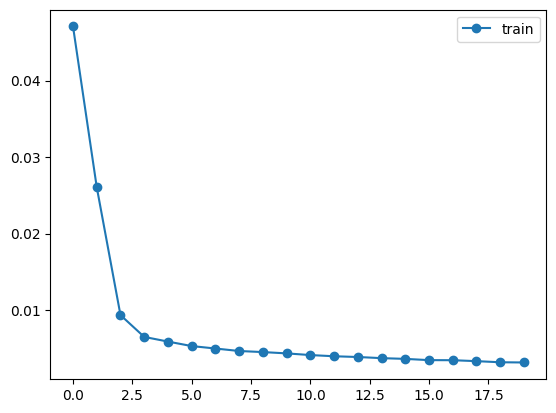

In [78]:
from tqdm import tqdm

d_input = 4 # this one should be 4 assume it is 'Volume','Open', 'Close', 'Scaled_sentiment'
d_output = 3 # prediction length be 3, this is confirmed
d_model = 32 # Lattent dim
q = 8 # Query size
v = 8 # Value size
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
attention_size = 30 # Attention window size
dropout = 0.1 # Dropout rate
pe = 'regular' # Positional encoding
chunk_mode = None
# Creating sequences
epochs = 20

# Creating the model
model = Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, dropout=dropout, chunk_mode=chunk_mode, pe=pe).to(device)
# model = TimeSeriesTransformer(num_features, num_outputs, dim_val, n_heads, n_decoder_layers, dropout_rate).to(device)
print(model)
# Loss function and optimizer
loss_function = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


# # Training parameters
# num_batches = int(len(X_train) / batch_size)

# # Training loop
# model.train()
# for epoch in range(epochs):
#   total_loss = 0
#   with tqdm(total=len(dataloader_train.dataset), desc=f"[Epoch {epoch+1:3d}/{epochs}]") as pbar:
#     for b, (x, y) in enumerate(dataloader_train):
#         start_index = b * batch_size
#         end_index = start_index + batch_size
#         x_batch = X_train_tensor[start_index:end_index]
#         y_batch = y_train_tensor[start_index:end_index]

#         # print('x_batch',x_batch.shape)
#         # print('y_batch',y_batch.shape)

#         # Forward pass
#         y_pred = model(x_batch)

#         # print('y_pred',y_pred.shape)

#         loss = loss_function(y_pred, y_batch)

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#   print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / num_batches}")

# print("Training complete.")

model.train()
# Prepare loss history
hist_loss = np.zeros(epochs)
for idx_epoch in range(epochs):
    running_loss = 0
    with tqdm(total=len(dataloader_train.dataset), desc=f"[Epoch {idx_epoch+1:3d}/{epochs}]") as pbar:
        for idx_batch, (x, y) in enumerate(dataloader_train):
            y = y.squeeze(-1)
            optimizer.zero_grad()
            netout = model(x.to(device))
            print(y.shape, netout.shape)
            loss = loss_function(y.to(device), netout)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
        
        train_loss = running_loss/len(dataloader_train)
        pbar.set_postfix({'loss': train_loss})
        
        hist_loss[idx_epoch] = train_loss
        
print("Training complete.")
        
plt.plot(hist_loss, 'o-', label='train')
plt.legend()



In [79]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 1167747


In [80]:

def inverse_transform_single_column(scaler, values, column_index, total_features):
    """
    Inverse transform a single column using a scaler trained on multi-feature data.

    Parameters:
        scaler: Fitted MinMaxScaler
        values: np.ndarray of shape (n_samples, 1) or (n_samples,)
        column_index: int, the column index this feature corresponds to in original data
        total_features: int, total number of features in the data the scaler was trained on

    Returns:
        np.ndarray of shape (n_samples,) with the inverse-transformed values
    """
    # Make sure values is 1D
    values = values.squeeze()
    
    # Create dummy array with the same number of features
    dummy = np.zeros((values.shape[0], total_features))
    
    # Place your values into the correct column
    dummy[:, column_index] = values

    # Apply inverse transform
    inversed = scaler.inverse_transform(dummy)

    # Return just the column you're interested in
    return inversed[:, column_index]
    
def eval_model(model, dataloader_test, scaler, output_length):
      predictions = []
      actuals = []
      model.eval()
      with torch.no_grad(): 
        # for x, y in enumerate(dataloader_test):
        for x, y in dataloader_test:
          y = y.squeeze(-1)
          modelout_pre  = model(x.to(device))
          modelout = modelout_pre
          predictions.append(modelout.cpu().numpy())
          actuals.append(y.cpu().numpy())
      print(actuals[0].shape)
      print(np.concatenate(actuals).shape)
      print(np.concatenate(predictions).shape)
      y_test_origin, y_pred_origin = np.concatenate(actuals), np.concatenate(predictions)
      # actuals = np.array(actuals)
      # predictions = np.array(predictions)

      # output_length = 3
      # predictions_np = np.concatenate(predictions, axis=0) # (155, 3, 6)
      # actuals_np = np.concatenate(actuals, axis=0) # (155, 3, 6)
      # print(predictions_np.shape)
      # print(actuals_np.shape)
      
      y_pred_origin = y_pred_origin.reshape(-1)
      y_test_origin = y_test_origin.reshape(-1)
      # print('y_pred_reshaped', y_pred_reshaped.shape)
      # print('y_test_reshaped', y_test_reshaped.shape)


      # y_test_origin = inverse_transform_single_column(scaler, y_test_origin, 2, 4)
      # y_pred_origin = inverse_transform_single_column(scaler, y_pred_origin, 2, 4)


      # print('y_test_origin', y_test_origin.shape)
      # print('y_pred_origin', y_pred_origin.shape)


      # # Create the directory for saving plots if it doesn't exist
      # os.makedirs("plot_saved", exist_ok=True)

      # # Plotting the results
      # plt.figure(figsize=(10, 6))
      # plt.plot(y_test_origin[:,2], label="Ground Truth", color='blue')  # Use the third element as the one for plotting 
      # plt.plot(y_pred_origin[:,2], label="Predicted", color='red')  # Use the third element as the one for plotting 
      # plt.title(f"{symbol}: Ground Truth vs Predicted")
      # plt.xlabel("Time Steps")
      # plt.ylabel("Values")
      # plt.legend()

      # # Save the plot as a PDF in the 'plot_saved' folder
      # plt.savefig(os.path.join("plot_saved", f"{symbol}_{num_stocks}.pdf"))



      # Calculate metrics
      mse = mean_squared_error(y_test_origin, y_pred_origin) 
      mae = mean_absolute_error(y_test_origin, y_pred_origin)
      r2 = r2_score(y_test_origin, y_pred_origin)
      print(f"MSE: {mse}, MAE: {mae}, R^2: {r2}")

In [81]:
eval_model(model, dataloader_test, scaler, output_length=3)

(64, 3)
(483, 3)
(483, 3)
MSE: 0.00275640981271863, MAE: 0.04269782081246376, R^2: 0.5183775124313297


In [ ]:
y_true = [[0.5, 1],[-1, 1],[7, -6]]
y_pred = [[0, 2],[-1, 2],[8, -5]]
mean_squared_error(y_true, y_pred)



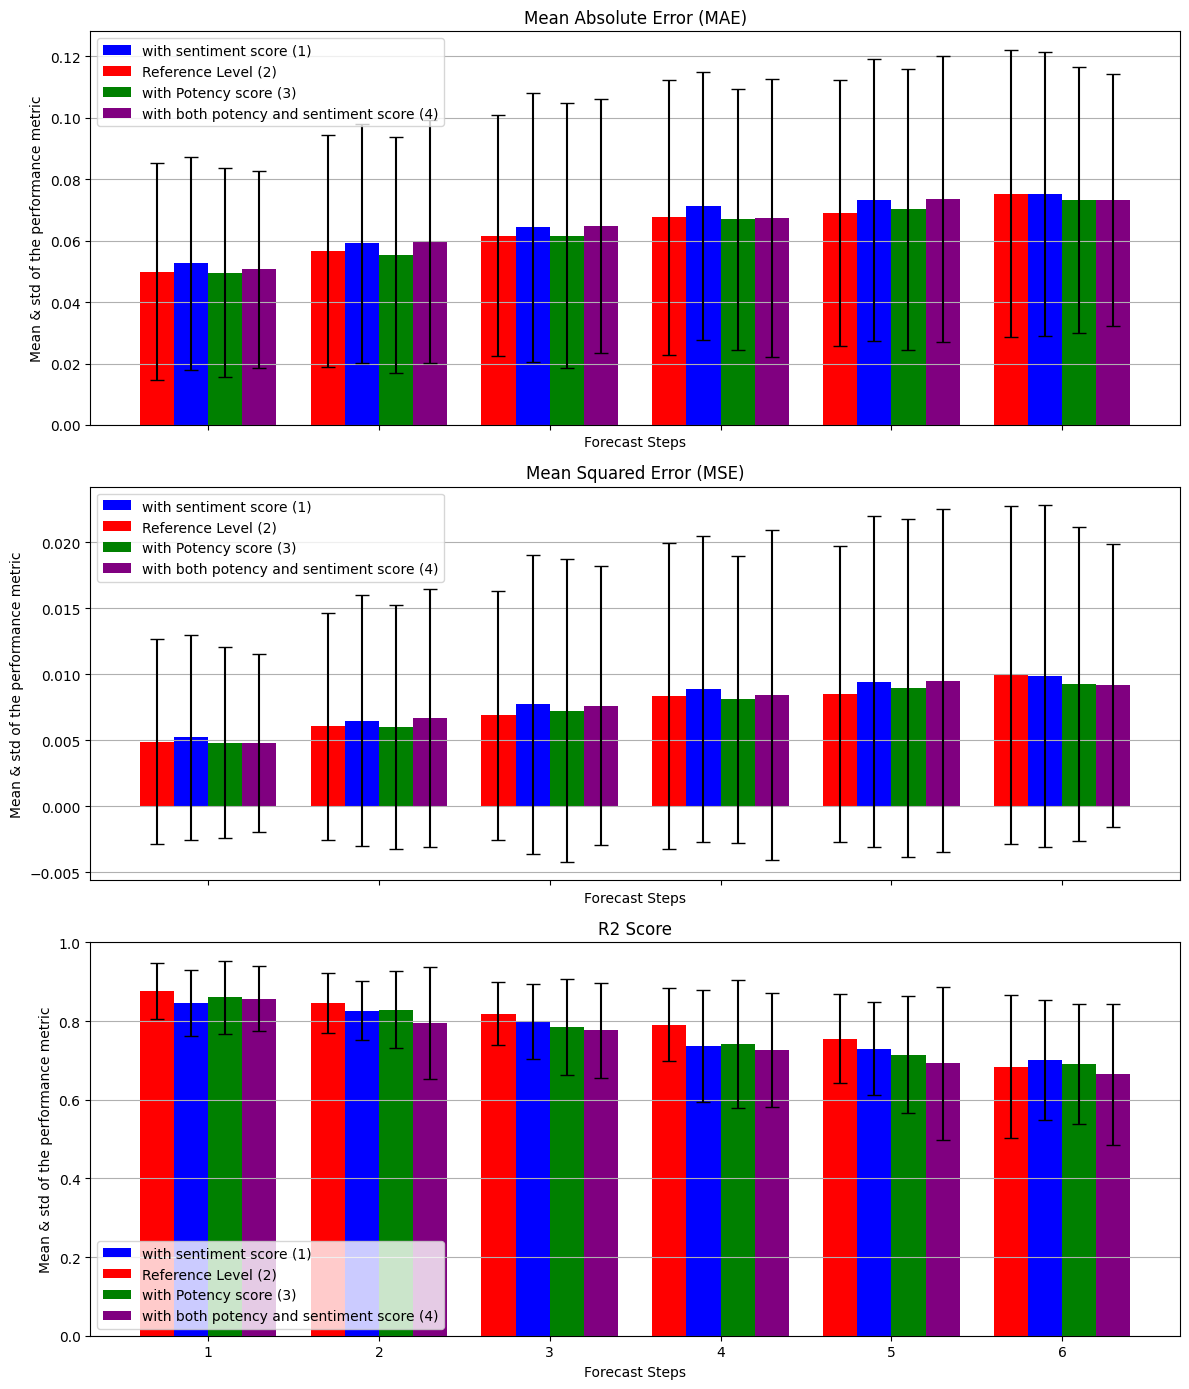

In [2]:
# Re-import libraries after reset
import numpy as np
import matplotlib.pyplot as plt

def compute_mean_std(metric_dict):
    steps = sorted(metric_dict.keys())
    means = [np.mean(metric_dict[step]) for step in steps]
    stds = [np.std(metric_dict[step]) for step in steps]
    return steps, means, stds
mae_1 = {1: [0.028396755, 0.051038727, 0.045456782, 0.06259797, 0.020325592, 0.042147826, 0.029714089, 0.043325122, 0.022423381, 0.046334278, 0.10761806, 0.037308004, 0.17612112, 0.054641552, 0.03412524, 0.037212748, 0.06653329, 0.051878493, 0.041609626], 2: [0.027193582, 0.06572189, 0.04827028, 0.06590928, 0.025666434, 0.038161878, 0.03183591, 0.04772879, 0.028198227, 0.060222037, 0.10199573, 0.038449112, 0.19879308, 0.05194824, 0.03811644, 0.042296447, 0.09669486, 0.06677054, 0.049422108], 3: [0.021392781, 0.07600362, 0.052334506, 0.07515161, 0.036778823, 0.044637255, 0.030744884, 0.056813486, 0.0280574, 0.055781603, 0.11583019, 0.030827092, 0.21591294, 0.05872138, 0.048263997, 0.045532547, 0.114794925, 0.067906, 0.045935526], 4: [0.032972362, 0.094330736, 0.05426085, 0.08007674, 0.047959946, 0.046792816, 0.03457839, 0.05686905, 0.025318788, 0.067494296, 0.119384706, 0.04054926, 0.22002819, 0.06545062, 0.052860186, 0.046169896, 0.119018994, 0.08093414, 0.06995103], 5: [0.026297465, 0.07354821, 0.05805531, 0.08250424, 0.044073034, 0.047684494, 0.037660223, 0.07061091, 0.033683315, 0.08116054, 0.11921889, 0.034934424, 0.22692895, 0.062762454, 0.052423052, 0.043388948, 0.13673346, 0.09091341, 0.06797415], 6: [0.0324527, 0.1076524, 0.06179237, 0.0822011, 0.04536393, 0.04808666, 0.038788278, 0.07247509, 0.031276487, 0.081329994, 0.12581937, 0.038619414, 0.23407708, 0.06926365, 0.05275929, 0.041154422, 0.118311435, 0.07762229, 0.06867622]}
mse_1 = {1: [0.001070312, 0.0034534258, 0.0029658964, 0.005452113, 0.0005856832, 0.0026245206, 0.0013555825, 0.0031024911, 0.00081708696, 0.0031588178, 0.016585689, 0.002168163, 0.03472488, 0.003940868, 0.0016441902, 0.002151784, 0.0070188404, 0.00395005, 0.0025860253], 2: [0.0010458922, 0.0056557176, 0.003343883, 0.006459939, 0.0009318202, 0.0022390804, 0.0015223768, 0.0036283412, 0.0012043413, 0.0050033918, 0.014973138, 0.002230615, 0.043566797, 0.0034500582, 0.0021388258, 0.0028205388, 0.013394809, 0.0062071155, 0.0033145116], 3: [0.00078615424, 0.007240482, 0.0040011657, 0.008328999, 0.0018264155, 0.0029594663, 0.0014796425, 0.004760339, 0.0011857455, 0.0042753723, 0.019037083, 0.0014937337, 0.050925326, 0.0044994736, 0.0032013496, 0.0030915043, 0.01786206, 0.006411921, 0.0031419639], 4: [0.0017743693, 0.010723583, 0.004086044, 0.009520127, 0.0032112817, 0.0033911539, 0.0018122814, 0.0048436476, 0.0009937536, 0.0063163093, 0.019927239, 0.002480548, 0.052885488, 0.0053483984, 0.003950206, 0.0033190686, 0.01923264, 0.008761231, 0.006294129], 5: [0.0012548657, 0.007194633, 0.0046401285, 0.010106328, 0.0027747399, 0.003484281, 0.0021635934, 0.0068093985, 0.001634597, 0.008747485, 0.019868342, 0.00193879, 0.056238867, 0.004763098, 0.003949353, 0.0029473389, 0.024022732, 0.010847811, 0.00597872], 6: [0.0017643402, 0.013583933, 0.0053857737, 0.010149045, 0.002909392, 0.003525252, 0.002310884, 0.0071217935, 0.001452874, 0.0089804595, 0.022006463, 0.0022086725, 0.05948407, 0.005895296, 0.004040472, 0.0026792297, 0.019455537, 0.008339527, 0.006111005]}
r2_1 = {1: [0.924895592598944, 0.8303375905327692, 0.897329179933219, 0.8311678703408097, 0.8717961781711867, 0.8253798685743422, 0.9003817075832468, 0.807070536003647, 0.8463211125383031, 0.9417066952792119, 0.9185549536913398, 0.9319511150642017, 0.8490275822621556, 0.566864927197926, 0.8619820484783226, 0.7242072403215053, 0.7962106645436857, 0.8477762089884124, 0.9111491321387527], 2: [0.88160946455378, 0.7330263007401855, 0.892231979842236, 0.8131442835458053, 0.7488167565013825, 0.9139340261676179, 0.8954378320057291, 0.8232472438185311, 0.7436250118337573, 0.9036908227145962, 0.8987077555604714, 0.9283601488889774, 0.8399728738475446, 0.724322844529696, 0.8227289462976788, 0.684060920880114, 0.7860398288768391, 0.7576314094314832, 0.917800148494627], 3: [0.8881258967129215, 0.7087800793072395, 0.8738236335001477, 0.7452681253496228, 0.7810740432137638, 0.8031477610669833, 0.8979063263241016, 0.743808896088407, 0.8119540307735201, 0.9179320706148446, 0.9000351064371158, 0.9319406715724918, 0.8334208109261569, 0.5540373873985536, 0.7852590381295935, 0.7323541080582572, 0.6909210388553712, 0.6928827920356306, 0.884735872078863], 4: [0.7374536109586439, 0.6240675467633295, 0.8667914967425473, 0.7055019187446272, 0.49177951522691477, 0.7977502197812897, 0.8712798763363054, 0.7273231783178215, 0.8110355488758898, 0.9040366006267803, 0.8965847008477861, 0.9265025117567902, 0.7561344447893896, 0.5827589647421741, 0.7516288260538567, 0.5684150821096812, 0.43400414363337214, 0.647833902497838, 0.9007474097426098], 5: [0.8133247243337015, 0.5836718677799907, 0.8484497584973032, 0.6297528806744008, 0.6041937969101088, 0.7512463705658315, 0.8784165216391888, 0.6827177046286159, 0.7255748147155212, 0.850778242296417, 0.8611669111002138, 0.9216574045534731, 0.6414775617269491, 0.7223948283191128, 0.7593489890101307, 0.5459689001696996, 0.6711647475468483, 0.5201903638956901, 0.8521229614398362], 6: [0.7294456577456222, 0.5753785169450083, 0.8232532530166068, 0.6404869414503076, 0.5263065178584563, 0.7082669766544123, 0.8716136202827371, 0.6637438633882412, 0.7043461582127694, 0.8616021952140432, 0.8599879100785774, 0.9255911294264997, 0.7611299703434685, 0.6560717314688309, 0.7756726568158621, 0.5874679456411656, 0.28997862362432675, 0.5316553752331419, 0.834641210078058]}
#r2_1 = {1: [0.9036218983526073, 0.3382255169171975, 0.9004656304224494, 0.4672339240055752, 0.5828978336965274, 0.719737568967846, 0.9291378991539864, 0.7128294267995893, 0.8582470773543998, 0.7840122807912312, 0.339645697389664, 0.9202145673477055, -2.29705715649405, 0.11930991323761497, 0.7769506046362818, 0.5647828087174042, 0.16782421574521855, -0.035232170588917144, 0.8221570879779494], 2: [0.8776013012038718, 0.2907966099172503, 0.879495758453516, 0.2916455654646688, 0.5529152307397511, 0.550894149628369, 0.9037671064858113, 0.49389717092412655, 0.8131887717892202, 0.6141579551732109, 0.07797151225981536, 0.935580744911505, -2.571328585850963, 0.05937814082064197, 0.8617365204744726, 0.421796573175956, -0.23321026177791504, -0.7068306190917248, 0.7218657132840247], 3: [0.8453231856691986, 0.28355400546215015, 0.8540848200942815, 0.20233151957648698, -0.11726763435206866, 0.4644293029422023, 0.8826052883334159, 0.41143665372504257, 0.7516648041570544, 0.5203594277299842, 0.27003964734851527, 0.9161456456205838, -3.3728017612791827, -0.16162302861344457, 0.6118698447179433, 0.4181650725100434, -0.6246198587489182, -0.6747154595102014, 0.47805602893426136], 4: [0.8472861307396532, -0.7434164887145993, 0.7883180462762784, 0.17676339793589424, -0.6217563715804058, 0.4725642902729492, 0.8475548983780876, 0.13900260824230926, 0.7204507250146197, 0.508467431923836, -0.014237694366600051, 0.8910855551314665, -3.414100496795368, 0.09117641089921058, 0.683606389819631, 0.5606671323840566, -1.1438484835180294, -0.6360263979628689, 0.4039266314332539], 5: [0.7715552356566441, -0.40241178266895505, 0.7801520833506106, -0.10077009425682304, -0.8036383498196844, 0.27272534704838014, 0.8024293974023246, -0.34386022288729157, 0.6736986106343845, 0.41295538688286615, 0.0996610853155735, 0.8431716101323519, -4.200883762636371, 0.049874852591856644, 0.35930261449051737, 0.45984284393484853, -1.064261089780521, -1.5878654501619485, 0.36556611051152266], 6: [0.7957913056040522, -1.6031843455081778, 0.7451505089525208, -0.1469995490691698, -1.8984826187883326, 0.35861234501251393, 0.8050546696104149, -0.9127317030734128, 0.6312341926637203, 0.3367689172512788, -0.07037153525671358, 0.8640356088954027, -4.733294733472141, -0.2507419197457865, 0.7169090109439511, 0.5102143091705394, -1.7478880441557512, -2.430634259343022, 0.3130945458138471]}

mae_2 = {1: [0.016503187, 0.04947586, 0.038995966, 0.05950548, 0.021961598, 0.034957737, 0.028088346, 0.04189126, 0.020597028, 0.055695053, 0.07966415, 0.029308688, 0.17907862, 0.040696025, 0.03178037, 0.04604924, 0.082948245, 0.05663215, 0.034465197], 2: [0.018135993, 0.065033495, 0.05247528, 0.064130515, 0.030741896, 0.037633386, 0.028089572, 0.045477074, 0.025082873, 0.05893949, 0.101801634, 0.033743527, 0.18786982, 0.03618725, 0.030383745, 0.0629865, 0.09406765, 0.061398666, 0.04203109], 3: [0.021718897, 0.065317936, 0.053203467, 0.069242544, 0.03491179, 0.041171536, 0.03351524, 0.046972487, 0.026454724, 0.06963359, 0.09822722, 0.036897775, 0.19699149, 0.053237494, 0.038890786, 0.0474994, 0.11344906, 0.073946014, 0.048388645], 4: [0.023084538, 0.09403432, 0.04814191, 0.07205511, 0.04143416, 0.042041197, 0.03382899, 0.05401387, 0.031159708, 0.07480817, 0.11987219, 0.036130857, 0.21839637, 0.051709812, 0.046168424, 0.045346018, 0.11499602, 0.090603076, 0.046161413], 5: [0.025169667, 0.084211044, 0.06194296, 0.076721445, 0.049178496, 0.04204215, 0.03661649, 0.054138154, 0.027988777, 0.07725603, 0.12082157, 0.030960644, 0.21515244, 0.05880005, 0.048289098, 0.039371014, 0.11451011, 0.086509064, 0.06002473], 6: [0.026812878, 0.1052732, 0.057113428, 0.091604486, 0.053477254, 0.047300518, 0.03426791, 0.0766981, 0.032889698, 0.08549039, 0.116505325, 0.03538006, 0.23363046, 0.079835564, 0.04605212, 0.039744545, 0.115834154, 0.09478356, 0.05759348]}
mse_2 = {1: [0.0004554132, 0.0034318138, 0.0022724925, 0.0051364275, 0.00068365573, 0.0019123275, 0.0012031914, 0.0029126294, 0.00064805103, 0.004154657, 0.009557845, 0.0013101836, 0.035892505, 0.002079155, 0.0014240554, 0.0031521586, 0.010163058, 0.00466667, 0.0018985274], 2: [0.00060374243, 0.005662599, 0.003889759, 0.006024938, 0.0013098051, 0.00222751, 0.0012333962, 0.0034049442, 0.0009671068, 0.0046616527, 0.014865521, 0.0017541333, 0.038994886, 0.0018321521, 0.0013582106, 0.005140061, 0.012914889, 0.00538735, 0.0027253137], 3: [0.0008876136, 0.0057341806, 0.003999726, 0.0070697987, 0.0017437255, 0.0026376103, 0.0017541685, 0.0036217596, 0.0010828897, 0.0064015435, 0.013890495, 0.0020615836, 0.04276454, 0.003460956, 0.002124103, 0.0033977896, 0.01753099, 0.00750761, 0.0034187182], 4: [0.0009991166, 0.010426464, 0.0033904347, 0.00787889, 0.002449486, 0.0027180645, 0.0017829327, 0.0044748355, 0.0014361237, 0.007315015, 0.020091062, 0.0019535432, 0.05203654, 0.003404969, 0.0029770683, 0.0031047796, 0.017983539, 0.010565695, 0.0031685454], 5: [0.001209268, 0.008764676, 0.005387329, 0.008858797, 0.0033406685, 0.0026893688, 0.0020522624, 0.0045925425, 0.0012057441, 0.0078108544, 0.02035896, 0.0015436686, 0.0507592, 0.0044758087, 0.003329983, 0.0024846413, 0.017963922, 0.00988782, 0.0048353253], 6: [0.0012237893, 0.013467016, 0.004659867, 0.012824815, 0.0039389236, 0.0035765795, 0.0018096027, 0.007946038, 0.001584007, 0.009550031, 0.01897016, 0.0019594259, 0.059204858, 0.007781804, 0.0030697645, 0.0025083653, 0.018397512, 0.011622031, 0.004677116]}
r2_2 = {1: [0.9478822962110758, 0.7017115808315822, 0.9216277322751852, 0.8254757557902603, 0.913866798279634, 0.9345244139916262, 0.914590957363798, 0.7690012900667292, 0.9097687172977724, 0.9362840656723381, 0.9405683791409074, 0.9464550709233532, 0.8844330728411116, 0.8651400447256868, 0.889141692503169, 0.7203479078607231, 0.8683238326528442, 0.854085718595244, 0.9163465607521862], 2: [0.924715814252874, 0.6795902171734809, 0.8757467206456232, 0.8274148113938893, 0.8209700205274679, 0.9070316178101897, 0.9217933854076898, 0.781275179959644, 0.8413846502365936, 0.918040824513867, 0.9327705990577511, 0.9298643692765113, 0.9023609296275057, 0.7601579674633511, 0.876890507174308, 0.707873283101039, 0.7457225554603766, 0.8286703890679058, 0.9008570770654214], 3: [0.8687608453836025, 0.6742509186387093, 0.8756028366336087, 0.7667136654464185, 0.7837398878792656, 0.9015740185125707, 0.8938072725008351, 0.7734843532208397, 0.7960199832521815, 0.9039460355340985, 0.9191023017942279, 0.9214419916120412, 0.8709239229476116, 0.7979912835717422, 0.8442970725350075, 0.6585050805112329, 0.7253980391597569, 0.7185216372851584, 0.8706036464417876], 4: [0.8618306650177425, 0.6951900037965717, 0.8893897778107769, 0.8032005303582944, 0.689225697288465, 0.8737012828945037, 0.8899343379627239, 0.6989463922616599, 0.7160833271172489, 0.881361199974896, 0.8862267151402277, 0.9251550019316692, 0.7229543355043878, 0.7496548293090655, 0.7673493636793944, 0.6936426284218997, 0.6060029211672482, 0.7994414450641674, 0.8851017219715225], 5: [0.8204241665940109, 0.6598423135640994, 0.8190214406339626, 0.7595131138277389, 0.6630901818431819, 0.88874825549927, 0.8756386376885072, 0.6196677563688313, 0.7587404367015473, 0.8782337190623699, 0.8654528182080723, 0.921752240400386, 0.7056716139034624, 0.5842073020569449, 0.7842270728227979, 0.577730919275516, 0.6904152836973753, 0.5986051119692573, 0.8836930894484428], 6: [0.8178965748495626, 0.4421814573434744, 0.8261725546979307, 0.7053644547088159, 0.2374326712373069, 0.8307482993126114, 0.8822227124894138, 0.6001775076487148, 0.7106446036585632, 0.8625971160276678, 0.8432934843311473, 0.9222075108618617, 0.6804474893914463, 0.5065055186986398, 0.7832740640655518, 0.4382629632243193, 0.5239551620179881, 0.5848610489163462, 0.799984680835506]}#r2_2 = {1: [0.903919509931457, 0.734425902465998, 0.922673345799857, 0.4366645247709946, 0.5888879937380842, 0.7321082059438069, 0.9353421593687512, 0.7538546975057048, 0.8733576616586788, 0.7474026974455663, 0.5688212714859479, 0.9604369860158173, -2.279518241739238, 0.5294799589202288, 0.8910642938846912, 0.5124117612935746, -0.11460204049329081, -0.5169886174216733, 0.6883873004903451], 2: [0.8954746076661546, 0.4861044669515776, 0.8925449918338028, 0.3888931232662719, 0.1700649653997227, 0.6876142834637345, 0.8642823206607152, 0.5816228160575194, 0.8446897353893461, 0.6744544243251986, 0.2071610176455354, 0.9532850799454375, -3.2866584474132994, 0.3800684103898243, 0.8639861976745198, 0.6633641399458214, -0.41495795177646944, -0.362623554340348, 0.6067850546863505], 3: [0.8599574867377204, 0.2184017519734337, 0.8698963006383142, 0.23371508301861355, -0.39157173436262904, 0.4632813664593173, 0.8831824850302696, 0.6000388227410656, 0.8124564439694247, 0.6392715350175775, 0.17407008911099353, 0.9265232990664185, -3.370403085209964, 0.07227293018273462, 0.7409126657344071, 0.5633543159176764, -0.15857401100820256, -1.0831443109221786, 0.5048004832535133], 4: [0.8469069233045925, 0.01693477523428799, 0.8416995236102072, -0.1512740961176675, -0.006881900068720137, 0.2616804191623915, 0.8649649920775093, 0.10195322217678426, 0.7735539672822779, 0.5523298325710446, -0.048168426345140736, 0.9198748926644531, -3.396722594231039, 0.3699060890754554, 0.8348359199540497, 0.44535680870522365, -0.6345405039404963, -1.153862150003285, 0.4846360007963991], 5: [0.8274623050205476, 0.21389547653492047, 0.7451756539040777, -0.15098307090373497, -0.6091885901591987, 0.316079628474211, 0.8229544402121971, 0.07864730428948308, 0.7185954189458166, 0.446868390085997, 0.12637236100370342, 0.9031316218824831, -4.123842810770919, -0.2008539122659656, 0.43495869783895413, 0.4644062885311261, -0.5837080947799347, -1.2012664918955243, 0.2031020585900144], 6: [0.7884608686795381, -0.2922588673584925, 0.7076232254162993, -0.21141412775190926, -1.6031376984211478, 0.16454476742414892, 0.8053370606870943, -0.6734426523770467, 0.6511458877610043, 0.42855680466022217, 0.07131433831465228, 0.8836198113298137, -4.383799589204247, 0.20238731299472756, 0.6335943672748198, 0.5004765740102151, -1.6781219570336905, -1.280522864810853, 0.31849568868183653]}

mae_3 = {1: [0.015530501, 0.047412347, 0.047284774, 0.056545883, 0.017860614, 0.039568383, 0.029566508, 0.04212439, 0.023810161, 0.053017255, 0.08326626, 0.025397617, 0.17289214, 0.028540146, 0.031016367, 0.06875783, 0.0691725, 0.048058994, 0.04155947], 2: [0.023550855, 0.046904787, 0.044312086, 0.06539902, 0.028264757, 0.03992904, 0.030358767, 0.04722368, 0.02547554, 0.064680934, 0.10059785, 0.024859207, 0.19495717, 0.027001152, 0.04198162, 0.060477223, 0.07903406, 0.06142953, 0.046908688], 3: [0.022218548, 0.05911805, 0.043949783, 0.0818426, 0.032262977, 0.0413869, 0.032131206, 0.05828683, 0.027045123, 0.069837645, 0.109639354, 0.028984966, 0.22031792, 0.045559872, 0.038575932, 0.066145614, 0.073553815, 0.06648134, 0.052465398], 4: [0.025942918, 0.10394248, 0.05407195, 0.08492351, 0.0382143, 0.042094678, 0.037892994, 0.073451474, 0.02864899, 0.06260689, 0.107711695, 0.036673028, 0.21203405, 0.043427438, 0.03863975, 0.05809922, 0.10701541, 0.06648858, 0.050125018], 5: [0.02846516, 0.09222134, 0.060184833, 0.08067584, 0.04406112, 0.040963646, 0.036915693, 0.07242796, 0.029631728, 0.076237135, 0.10589512, 0.03865756, 0.23452352, 0.033641275, 0.04307578, 0.057687476, 0.107668415, 0.085142866, 0.06534945], 6: [0.029773796, 0.07969194, 0.059853613, 0.08580143, 0.048793413, 0.043122683, 0.035942078, 0.07466378, 0.036421478, 0.08723174, 0.11061101, 0.03781546, 0.22417232, 0.06132112, 0.051620442, 0.052672792, 0.122684374, 0.08179417, 0.067096576]}
mse_3 = {1: [0.00040441885, 0.0030929532, 0.0031462705, 0.0047720894, 0.00046823418, 0.0024886369, 0.0013504217, 0.0030167117, 0.000870831, 0.0038995584, 0.010247302, 0.0010065291, 0.033633057, 0.0015121443, 0.0017134966, 0.0061192308, 0.007422812, 0.0034736288, 0.0025627443], 2: [0.0010428804, 0.0031932776, 0.002786157, 0.006412303, 0.0011300654, 0.0024032316, 0.001408458, 0.003559937, 0.0009981442, 0.0056022806, 0.0145085445, 0.0010164545, 0.0425033, 0.0011984754, 0.003008149, 0.0050899056, 0.009437668, 0.005346199, 0.0032126897], 3: [0.0008519866, 0.004796144, 0.002864267, 0.009824534, 0.0014982111, 0.002548294, 0.0016094708, 0.00476286, 0.0011846964, 0.006615967, 0.016973931, 0.0012624642, 0.053331513, 0.0028208694, 0.0024490915, 0.0060160127, 0.008304922, 0.0060802186, 0.0039526927], 4: [0.001229626, 0.013030909, 0.004181844, 0.0107071465, 0.0021062908, 0.0026545036, 0.0021725958, 0.0072029172, 0.0012082536, 0.0053642956, 0.016294578, 0.0020030427, 0.04961753, 0.002569581, 0.0026712476, 0.004999364, 0.016058898, 0.006216905, 0.003582741], 5: [0.0013212509, 0.010563855, 0.005134943, 0.009658063, 0.0027331733, 0.0024791472, 0.002020949, 0.0071135913, 0.0013191656, 0.007700566, 0.015751593, 0.0021751248, 0.059989955, 0.0019244823, 0.0033273248, 0.0050865645, 0.016328953, 0.009721553, 0.0059037744], 6: [0.0015417086, 0.008414488, 0.0050331787, 0.011201623, 0.0032777374, 0.0027250212, 0.001980452, 0.0074767135, 0.0018907469, 0.009926892, 0.016976343, 0.0021251647, 0.05495828, 0.004809982, 0.0040795114, 0.0042047114, 0.020380998, 0.008868232, 0.005828461]}
r2_3 = {1: [0.9481959182920259, 0.8339224314351534, 0.8963381394285268, 0.826718183075527, 0.9216769344276314, 0.8388348436162577, 0.9266290669771973, 0.807521801866879, 0.860509016781569, 0.9273833429661894, 0.9330588811967743, 0.9541579680419183, 0.9457293291471941, 0.6540485381468425, 0.8912029124623957, 0.5977032930802257, 0.849470463174032, 0.8270772449426482, 0.907654390998217], 2: [0.8784037383999708, 0.7441155525295424, 0.9008188683780831, 0.8223353224814702, 0.8313159292675362, 0.8805513720493898, 0.9230129723745764, 0.7303654863320885, 0.8116792621483488, 0.8980562316331294, 0.9207858212824149, 0.9517891291859873, 0.7976430417163636, 0.7067982003020089, 0.856954049008603, 0.5208199287151529, 0.8381799928657122, 0.849670757772283, 0.8904810483684609], 3: [0.874419235135153, 0.6923327793122915, 0.8987038025741028, 0.5672003020208373, 0.6671824519365149, 0.8438190049440404, 0.9010858293637236, 0.7736046893610212, 0.7281264603859441, 0.8752457118098886, 0.82538380313428, 0.9396720275074156, 0.8730459904961299, 0.6877674545829511, 0.8814047677422288, 0.46093596546424975, 0.7960234899233285, 0.7738708439541078, 0.8595415126116768], 4: [0.8357320264012325, 0.5064622380351415, 0.8580925270770878, 0.5361775294461015, 0.6560938914082847, 0.8567185282776195, 0.8986820342553232, 0.7238657789896061, 0.8026008535742571, 0.888442195433008, 0.8439275873396554, 0.9294116125811015, 0.7433987854212558, 0.5888999877254709, 0.8323318809668208, 0.30162265192694854, 0.6156899245147771, 0.7777585774906266, 0.8872444985522232], 5: [0.829924491718504, 0.539055699652302, 0.8028438321024287, 0.635848562882828, 0.6652375810070656, 0.7953169604424943, 0.9006701578233601, 0.6887998289000399, 0.7492199964957427, 0.8282438072895687, 0.8245857401486716, 0.9145312759504908, 0.8416723144886621, 0.5843619309815837, 0.8064271164441914, 0.3704129409475546, 0.5858405167506255, 0.45350906492877424, 0.7660672467950451], 6: [0.7659614630468987, 0.5579780238727066, 0.816182406786262, 0.61792066077485, 0.5325524078502033, 0.7857218510457908, 0.8778692402660245, 0.7280809871390901, 0.5795800987241667, 0.814794534936677, 0.7783237129080104, 0.920933950299285, 0.589659400095826, 0.559223468936027, 0.84473805608185, 0.38717514214608095, 0.4207470866413614, 0.707893111885614, 0.8495344407227563]}#r2_3 = {1: [0.9055003245205016, 0.570118324996949, 0.9007652063343542, 0.4508184670958698, 0.8071381626598488, 0.6590239434348307, 0.922705838907587, 0.6569536395834392, 0.8455126687496327, 0.7799266874663959, 0.3883104827271968, 0.9458042063846733, -2.6222035332372675, 0.39815080969077554, 0.8230208166739573, 0.3794637444122192, 0.2378422797603399, -0.2676149741521452, 0.5336339838788009], 2: [0.8888811591631931, 0.39176294844949133, 0.8819918685698968, 0.2872536310598799, 0.5976093795793007, 0.5707012117137453, 0.8980803798907189, 0.36248719420109543, 0.8171736766392628, 0.6875347351586589, 0.40034108665148793, 0.918121629823685, -3.0794004220669358, 0.8005647303114201, 0.6738034044204039, -0.13749331853024938, 0.022922306571151574, -0.47692241473119745, 0.5388456658766143], 3: [0.8604592133087409, 0.20469485666290832, 0.83737307890445, 0.0503555416651128, 0.17650165617284275, 0.5234156277659584, 0.8796823519766261, 0.18064326387441387, 0.7850889611152465, 0.6169884198450564, 0.22871005026006141, 0.908133585484321, -3.562661882597724, -0.5991825276693121, 0.6566588664249842, 0.1157059451192104, -0.40006951214572495, -0.8465153538178358, 0.44261820563350374], 4: [0.8368559998099274, 0.19672300940154563, 0.791517765741828, -0.009896187480305851, -0.5113457260566721, 0.4623399540241022, 0.8462919370893571, 0.15658307641662395, 0.720924075391113, 0.3916242201310157, 0.03644717200072911, 0.8844062350916139, -3.937829740425702, -0.21440413818955872, 0.7402345219416899, -0.8299999641167322, -0.8851903930425598, -0.7484199574748833, 0.3803761567518853], 5: [0.8036958473891976, -0.5219134293033725, 0.7789737088910133, -0.23318309843858587, -0.1368985314507638, 0.3510326725296665, 0.8238545800469599, 0.13298665324177283, 0.6974804380721298, 0.4032197318562697, 0.16386374380939772, 0.8800288026548078, -3.631653957361994, 0.01347233193862618, 0.6828143632724992, -0.29162023765093403, -1.4057817241981754, -1.4177801664392025, 0.2656055598005519], 6: [0.7932642137631927, -0.48327959365006046, 0.7467061456252619, -0.22556271440591802, -1.0988545126719336, 0.34819939372525566, 0.7742837752261135, -0.35471769325698843, 0.6906750016251364, 0.3838249805715648, 0.09765655746178248, 0.8357222941636908, -3.853004958842389, 0.2917579373136395, 0.35704107929608075, -0.1019611927467321, -1.0796973208152938, -1.5923763154134223, 0.1158935319183716]}

mae_4 = {1: [0.018630946, 0.047417644, 0.043958873, 0.065889716, 0.018348958, 0.03674804, 0.029962916, 0.034623098, 0.027867243, 0.047848303, 0.08723838, 0.041922532, 0.16682762, 0.034612864, 0.033497076, 0.06717043, 0.059259128, 0.053223573, 0.048353504], 2: [0.028786108, 0.0817355, 0.051813222, 0.068247326, 0.030439477, 0.039359257, 0.025624393, 0.05047188, 0.023582261, 0.049767382, 0.108310945, 0.04012827, 0.200857, 0.039588787, 0.034103267, 0.069799505, 0.076256074, 0.068162955, 0.047193382], 3: [0.023343531, 0.07369918, 0.050923068, 0.0785802, 0.027997518, 0.044044845, 0.03285833, 0.045874946, 0.027438208, 0.06172841, 0.108663194, 0.04021737, 0.21091738, 0.0746764, 0.04000077, 0.05978332, 0.09610836, 0.07393243, 0.057628535], 4: [0.02770288, 0.078456126, 0.05160215, 0.082811795, 0.038938, 0.043077152, 0.036745198, 0.063109025, 0.032076787, 0.072063126, 0.10737486, 0.040036395, 0.23016141, 0.03052492, 0.042006746, 0.051331647, 0.108552635, 0.08649906, 0.058200363], 5: [0.026841916, 0.10735851, 0.053415395, 0.07948338, 0.04149799, 0.045971517, 0.03137436, 0.07840566, 0.029256772, 0.06974527, 0.10527379, 0.033823155, 0.236063, 0.08544406, 0.042790763, 0.07427213, 0.11416144, 0.074219584, 0.06652562], 6: [0.037345983, 0.07344633, 0.05586847, 0.0831697, 0.044323906, 0.04745462, 0.04441332, 0.07150278, 0.032380152, 0.07577562, 0.12576744, 0.03701305, 0.2100047, 0.0694522, 0.04395445, 0.06000177, 0.117560275, 0.09706569, 0.064280495]}
mse_4 = {1: [0.00066399225, 0.0032124876, 0.0027853104, 0.0061572827, 0.00049356837, 0.0020550715, 0.0013707756, 0.0020145855, 0.001083437, 0.003304399, 0.011116115, 0.0025050403, 0.031369895, 0.0016356502, 0.0019522357, 0.0059449947, 0.0056188093, 0.004068787, 0.003334241], 2: [0.00125489, 0.008447916, 0.0037271911, 0.006914706, 0.0012716899, 0.0023661978, 0.00104083, 0.0038083221, 0.0008440377, 0.0035873784, 0.016761001, 0.0024843805, 0.044864785, 0.002023017, 0.0020461685, 0.006539582, 0.008890899, 0.0063819177, 0.0032365248], 3: [0.0009361463, 0.006887873, 0.0036044256, 0.00916248, 0.0011196935, 0.002913554, 0.0016806829, 0.0034640755, 0.0011772931, 0.0052805003, 0.0166173, 0.0025203684, 0.049122, 0.006811878, 0.0027831225, 0.005240612, 0.013426719, 0.007462739, 0.004661051], 4: [0.0013217096, 0.008014672, 0.003882752, 0.010327626, 0.0022041034, 0.0027160172, 0.0020476945, 0.0056766905, 0.0015208183, 0.006951688, 0.01626895, 0.002523936, 0.057844054, 0.0014287522, 0.0028331608, 0.0040031504, 0.01629705, 0.009875044, 0.0044796537], 5: [0.0011795588, 0.013809557, 0.00412918, 0.009492472, 0.002492792, 0.0031203493, 0.0015413666, 0.008225034, 0.0013015657, 0.0065728133, 0.015701432, 0.0018057089, 0.060761545, 0.008974974, 0.002949693, 0.0076475115, 0.017588492, 0.0075605414, 0.0058908323], 6: [0.00222407, 0.0072462424, 0.004610169, 0.010399416, 0.0027605477, 0.0034245178, 0.0029402012, 0.0070417062, 0.0015769474, 0.007844904, 0.02208701, 0.0021406005, 0.048435904, 0.0062022908, 0.0030842032, 0.005293471, 0.018961832, 0.012276861, 0.005631789]}
r2_4 = {1: [0.9059550382544699, 0.7770432584049844, 0.9104459680086345, 0.7511352554625532, 0.8994741316044232, 0.8890944766311064, 0.9242705664710724, 0.8493275922538226, 0.8804482965853448, 0.9190014358329947, 0.9205930131952101, 0.9288195861780858, 0.9192526006024242, 0.808614470920332, 0.8743226051052746, 0.5941039105438469, 0.7840648015383241, 0.8290996352037258, 0.9157366959358866], 2: [0.8566496630305515, 0.6409940112156773, 0.8638164537924256, 0.7237504624254716, 0.8024554247583502, 0.8496781957650639, 0.9363803250890967, 0.7783500363366309, 0.8540857222039826, 0.9263131571894785, 0.8938949864046736, 0.9289049527414418, 0.8941400612492131, 0.5243408011593768, 0.8821630836854616, 0.36673937149455327, 0.7492373575330707, 0.7704292749439389, 0.8675285508061148], 3: [0.861887214272042, 0.7120955059707466, 0.8996666121277216, 0.6889590561935173, 0.7652568604333115, 0.8261789217627441, 0.8848951142690678, 0.7880773577727186, 0.7413853446361659, 0.9126790054886772, 0.8622680094730529, 0.9291469995919813, 0.7304495700635951, 0.6556108342848636, 0.8499553112399075, 0.39980817101591815, 0.7044017530235511, 0.6904418448125793, 0.8494913511777211], 4: [0.8028325551189193, 0.61682523974975, 0.8645182042332922, 0.6261624482047519, 0.3728400864469369, 0.7529148514984074, 0.8867804310564638, 0.617958821200159, 0.7128693418689382, 0.8830590312008291, 0.891431302809401, 0.9225878627905033, 0.7652061099799484, 0.666936820491002, 0.7977122289675348, 0.5566539560947319, 0.6416074220910917, 0.5423236803345397, 0.8800448601990303], 5: [0.8420579914568826, 0.4866734932743473, 0.842244079422668, 0.7455430594578238, 0.3087416115595829, 0.8015260058597251, 0.9026750071571056, 0.5770124730792833, 0.7228865193608488, 0.8468125043455836, 0.7967171795554522, 0.9233755333153008, 0.6405790064006145, 0.43069546484425814, 0.8593591453832555, 0.24205795977020242, 0.6699573026333807, 0.6754388728607423, 0.8410137100014843], 6: [0.6565813576893929, 0.6050840894976333, 0.831649810565684, 0.6891932504759612, 0.5193659344539285, 0.7426687426127924, 0.862115709979606, 0.6027246083592119, 0.6659287267342002, 0.8544183009780582, 0.8119386670914961, 0.9157139937965044, 0.7383132692088055, 0.3886803366337649, 0.8229405970126331, 0.35750105735543375, 0.3951525933038325, 0.36272858300967087, 0.8058636541351141]}

# # Function to compute mean and std
steps, mae_mean1, mae_std1 = compute_mean_std(mae_1)
_, mae_mean2, mae_std2 = compute_mean_std(mae_2)
_, mae_mean3, mae_std3 = compute_mean_std(mae_3)
_, mae_mean4, mae_std4 = compute_mean_std(mae_4)

_, mse_mean1, mse_std1 = compute_mean_std(mse_1)
_, mse_mean2, mse_std2 = compute_mean_std(mse_2)
_, mse_mean3, mse_std3 = compute_mean_std(mse_3)
_, mse_mean4, mse_std4 = compute_mean_std(mse_4)

_, r2_mean1, r2_std1 = compute_mean_std(r2_1)
_, r2_mean2, r2_std2 = compute_mean_std(r2_2)
_, r2_mean3, r2_std3 = compute_mean_std(r2_3)
_, r2_mean4, r2_std4 = compute_mean_std(r2_4)

# Plotting grouped bars
bar_width = 0.20  # Adjusted to accommodate 4 bars per group
x = np.array(steps)
offset = bar_width

fig, axs = plt.subplots(3, 1, figsize=(12, 14), sharex=True)

# MAE
axs[0].bar(x - 0.5 * offset, mae_mean1, yerr=mae_std1, width=bar_width, color='blue', label='with sentiment score (1)', capsize=5)
axs[0].bar(x - 1.5 * offset, mae_mean2, yerr=mae_std2, width=bar_width, color='red', label='Reference Level (2)', capsize=5)
axs[0].bar(x + 0.5 * offset, mae_mean3, yerr=mae_std3, width=bar_width, color='green', label='with Potency score (3)', capsize=5)
axs[0].bar(x + 1.5 * offset, mae_mean4, yerr=mae_std4, width=bar_width, color='purple', label='with both potency and sentiment score (4)', capsize=5)
axs[0].set_title("Mean Absolute Error (MAE)")

# MSE
axs[1].bar(x - 0.5 * offset, mse_mean1, yerr=mse_std1, width=bar_width, color='blue', label='with sentiment score (1)', capsize=5)
axs[1].bar(x - 1.5 * offset, mse_mean2, yerr=mse_std2, width=bar_width, color='red', label='Reference Level (2)', capsize=5)
axs[1].bar(x + 0.5 * offset, mse_mean3, yerr=mse_std3, width=bar_width, color='green', label='with Potency score (3)', capsize=5)
axs[1].bar(x + 1.5 * offset, mse_mean4, yerr=mse_std4, width=bar_width, color='purple', label='with both potency and sentiment score (4)', capsize=5)
axs[1].set_title("Mean Squared Error (MSE)")

# R2
axs[2].bar(x - 0.5 * offset, r2_mean1, yerr=r2_std1, width=bar_width, color='blue', label='with sentiment score (1)', capsize=5)
axs[2].bar(x - 1.5 * offset, r2_mean2, yerr=r2_std2, width=bar_width, color='red', label='Reference Level (2)', capsize=5)
axs[2].bar(x + 0.5 * offset, r2_mean3, yerr=r2_std3, width=bar_width, color='green', label='with Potency score (3)', capsize=5)
axs[2].bar(x + 1.5 * offset, r2_mean4, yerr=r2_std4, width=bar_width, color='purple', label='with both potency and sentiment score (4)', capsize=5)
axs[2].set_title("R2 Score")

# Formatting
for ax in axs:
    ax.set_xlabel("Forecast Steps")
    ax.set_ylabel("Mean & std of the performance metric")
    ax.grid(True, axis='y')
    ax.legend()

plt.tight_layout()
plt.savefig('final_results_transformers.pdf')

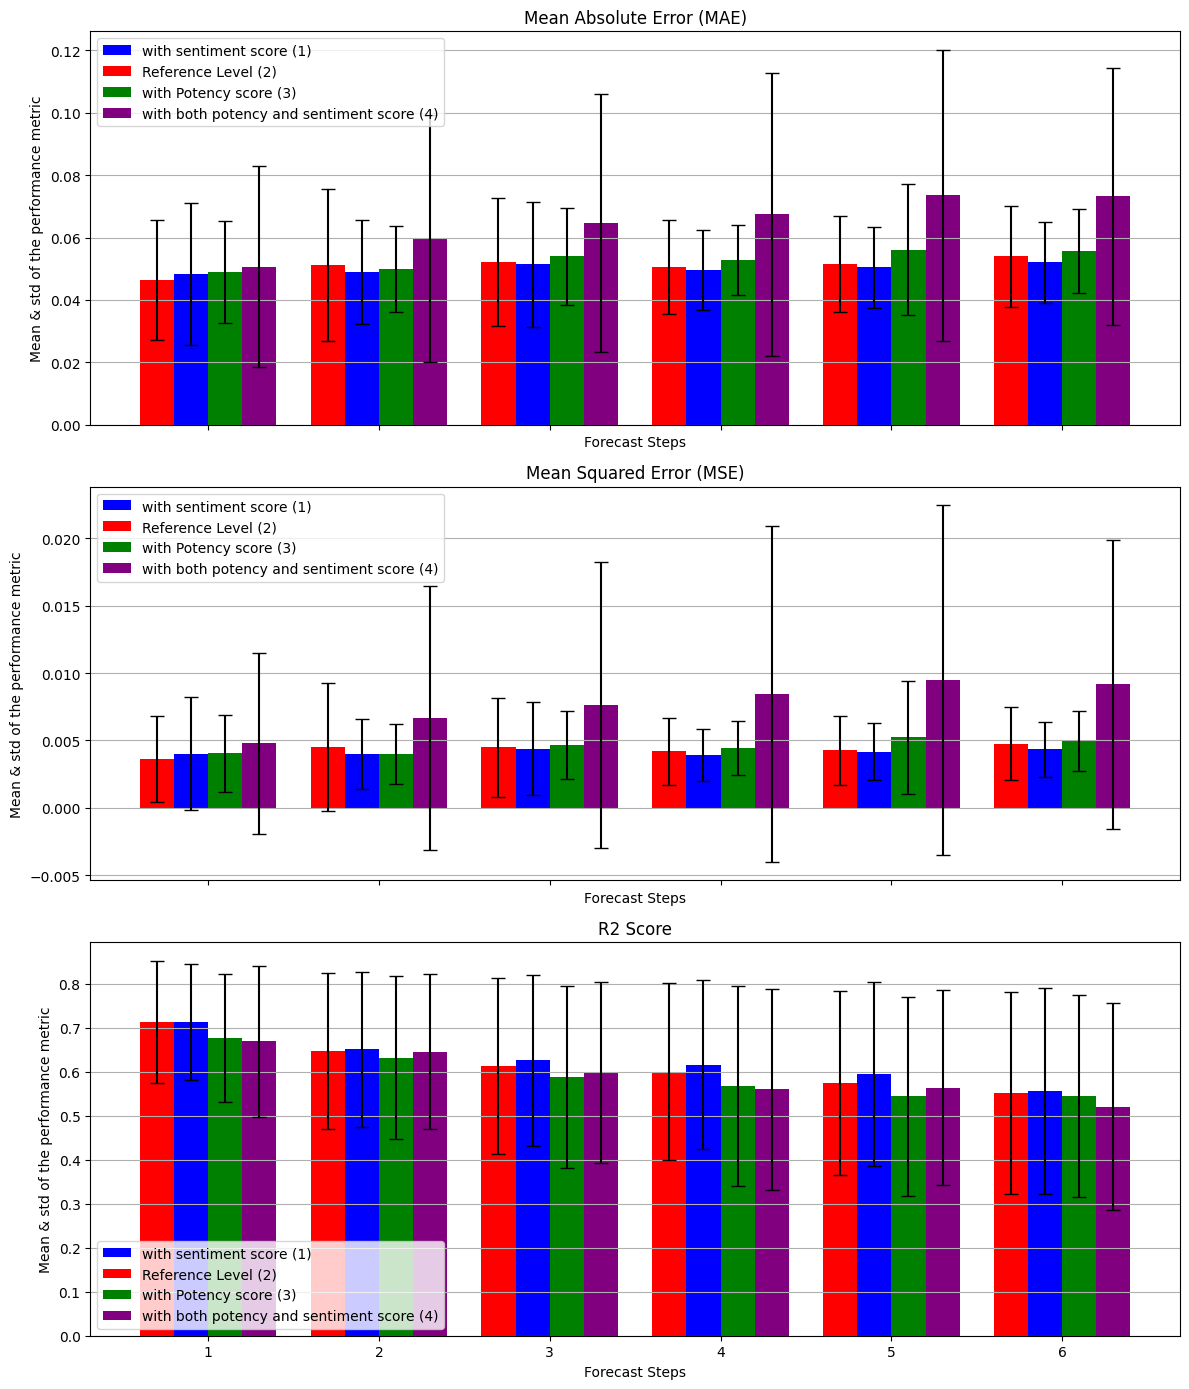

In [3]:
# Re-import libraries after reset
import numpy as np
import matplotlib.pyplot as plt

def compute_mean_std(metric_dict):
    steps = sorted(metric_dict.keys())
    means = [np.mean(metric_dict[step]) for step in steps]
    stds = [np.std(metric_dict[step]) for step in steps]
    return steps, means, stds
mae_1 = {1: [0.038062286, 0.046477575, 0.056572963, 0.058352634, 0.021669373, 0.03127977, 0.040762324, 0.049646337, 0.03128489, 0.048348732, 0.068307556, 0.042993646, 0.13317835, 0.035620615, 0.04968508, 0.035306815, 0.050545964, 0.04777863, 0.03310809], 2: [0.04210735, 0.05441339, 0.061368406, 0.06546481, 0.024562916, 0.031127194, 0.042283066, 0.053896822, 0.03841889, 0.0581327, 0.06380817, 0.03935316, 0.099484935, 0.040679812, 0.047100604, 0.036620684, 0.060131703, 0.038676713, 0.033859648], 3: [0.047361106, 0.056414884, 0.061004948, 0.0633166, 0.02523419, 0.02622252, 0.04397816, 0.0600955, 0.037657082, 0.051189274, 0.06956938, 0.040327083, 0.12027771, 0.039619032, 0.05193677, 0.03945261, 0.057950813, 0.040001787, 0.044776447], 4: [0.052059468, 0.051004387, 0.060290698, 0.07050085, 0.0325113, 0.027983386, 0.044399794, 0.05926202, 0.038461998, 0.05359525, 0.064296156, 0.045476805, 0.07789442, 0.038549323, 0.049992036, 0.040378157, 0.056173787, 0.040802535, 0.038698528], 5: [0.047344662, 0.051212627, 0.06607784, 0.064687386, 0.029254612, 0.032702524, 0.04528394, 0.06364927, 0.0394646, 0.058813546, 0.070264034, 0.03816868, 0.06620173, 0.04153608, 0.054337, 0.041410036, 0.06857314, 0.040855948, 0.038483858], 6: [0.05129818, 0.06103665, 0.068740204, 0.06788365, 0.028004065, 0.03158961, 0.04783487, 0.060924977, 0.04125599, 0.0602407, 0.06720912, 0.042157616, 0.068710305, 0.043909293, 0.05482638, 0.040631812, 0.069078445, 0.04032048, 0.043177914]}
mse_1 ={1: [0.0020608876, 0.0030825133, 0.00472829, 0.0051756264, 0.00063852983, 0.0015496417, 0.0025757148, 0.0036610605, 0.001596408, 0.0037543369, 0.0076986006, 0.002779543, 0.020446751, 0.001778603, 0.003583513, 0.0020583274, 0.0040284763, 0.003513019, 0.0017209535], 2: [0.0027045656, 0.004139556, 0.005463947, 0.0062187407, 0.0008182449, 0.0015789858, 0.002766021, 0.0045729736, 0.00230561, 0.0056045055, 0.006594365, 0.002273555, 0.012298156, 0.0023455578, 0.003259297, 0.002204676, 0.005913678, 0.0026091565, 0.0018013616], 3: [0.0031054704, 0.004477746, 0.0054223333, 0.0061153662, 0.0009255402, 0.0011182913, 0.0029758385, 0.005567021, 0.0022516884, 0.0042681466, 0.007955548, 0.0024047166, 0.016908271, 0.0022859154, 0.0039123115, 0.0025792427, 0.005481632, 0.002826311, 0.00278611], 4: [0.0036680403, 0.0035736836, 0.005431182, 0.007304033, 0.0014049326, 0.001275528, 0.0030006284, 0.00536625, 0.0024022467, 0.0046430654, 0.0067367605, 0.0030174928, 0.0083271, 0.0021867424, 0.003641627, 0.00274768, 0.004755697, 0.0027925412, 0.002249396], 5: [0.0031449457, 0.0035950278, 0.0063212775, 0.0064206026, 0.0011482079, 0.001677274, 0.0031412973, 0.006200266, 0.002550189, 0.0054895775, 0.008125098, 0.0022600552, 0.0069266623, 0.0024806457, 0.0042431774, 0.0027003954, 0.007523845, 0.0028690496, 0.002231048], 6: [0.0036407867, 0.005143177, 0.0065609864, 0.0068605794, 0.001064962, 0.0015720866, 0.0033660121, 0.0057407836, 0.002895651, 0.0056125494, 0.007223175, 0.0026463973, 0.0071362504, 0.0027523092, 0.0043210387, 0.0026595225, 0.007897531, 0.002846815, 0.0026486127]}
r2_1 = {1: [0.6838908137125634, 0.4887011494789871, 0.8331774620096073, 0.6285645113422481, 0.7568167237352236, 0.8860397458280024, 0.8055012387238321, 0.6379764501652503, 0.6246429696557533, 0.8942682004407563, 0.7995599590451545, 0.8968698286226995, 0.8049161036329293, 0.5693430744491905, 0.6500612008950075, 0.45537075493586243, 0.6596410091725953, 0.6393693191354837, 0.8454098616521295], 2: [0.5172560362772644, 0.3619976884478217, 0.7847954364481402, 0.5647815827333289, 0.6945678422460708, 0.891255221526015, 0.7901403359384183, 0.5522862572144074, 0.39952750172962104, 0.8539688124098661, 0.8015780098659442, 0.8916969602068829, 0.7689398000170056, 0.4202375317667999, 0.6755511801676344, 0.3744533095991973, 0.5905087078348763, 0.5976414410613056, 0.8433640686211714], 3: [0.4750798379228459, 0.2749337936140853, 0.7909224320939575, 0.5522923268259612, 0.6444681727958064, 0.8891448432321261, 0.7736447564067663, 0.508280798531048, 0.4135876163380731, 0.8329311466437601, 0.7876383191399889, 0.8810201305457561, 0.7906987414773231, 0.4190140949027804, 0.6235761037368113, 0.26830923868541323, 0.5839936824071306, 0.5467875238115559, 0.8400848645102291], 4: [0.378162602021329, 0.2789178162040884, 0.7922009999791413, 0.5199017834161809, 0.6127311453742219, 0.876381730604838, 0.7713192467044008, 0.48240453072807704, 0.4034843513061793, 0.8240353593777552, 0.7839596257076186, 0.8818773789543181, 0.7492826377385947, 0.43494096145734995, 0.6126887225409137, 0.29923083242318504, 0.5668858634273823, 0.6141541629070046, 0.8325186194034551], 5: [0.433393235024906, 0.26398449501552695, 0.7491365849728082, 0.5116732662404452, 0.6630948986599965, 0.8873827568271107, 0.7686399921931324, 0.4220975307440847, 0.373965124116299, 0.8011331669799686, 0.7615535115118195, 0.8764512397952561, 0.743021056347992, 0.3564883227691833, 0.5494321695677045, 0.16972313278137646, 0.5701969343935125, 0.5641687511838077, 0.8362082966193818], 6: [0.2778447025609415, 0.16206358588544933, 0.7330075522963256, 0.45004615150226496, 0.5352227868016519, 0.8792236984010993, 0.7435449855534666, 0.38233445724634096, 0.3067856540054955, 0.7838176210298649, 0.7793294703407558, 0.8678636409434941, 0.7374048049934381, 0.2557132107080768, 0.5568488228561493, 0.202454356115662, 0.5204984073493741, 0.5592562118673117, 0.839275754708835]}#r2_1 = {1: [0.9036218983526073, 0.3382255169171975, 0.9004656304224494, 0.4672339240055752, 0.5828978336965274, 0.719737568967846, 0.9291378991539864, 0.7128294267995893, 0.8582470773543998, 0.7840122807912312, 0.339645697389664, 0.9202145673477055, -2.29705715649405, 0.11930991323761497, 0.7769506046362818, 0.5647828087174042, 0.16782421574521855, -0.035232170588917144, 0.8221570879779494], 2: [0.8776013012038718, 0.2907966099172503, 0.879495758453516, 0.2916455654646688, 0.5529152307397511, 0.550894149628369, 0.9037671064858113, 0.49389717092412655, 0.8131887717892202, 0.6141579551732109, 0.07797151225981536, 0.935580744911505, -2.571328585850963, 0.05937814082064197, 0.8617365204744726, 0.421796573175956, -0.23321026177791504, -0.7068306190917248, 0.7218657132840247], 3: [0.8453231856691986, 0.28355400546215015, 0.8540848200942815, 0.20233151957648698, -0.11726763435206866, 0.4644293029422023, 0.8826052883334159, 0.41143665372504257, 0.7516648041570544, 0.5203594277299842, 0.27003964734851527, 0.9161456456205838, -3.3728017612791827, -0.16162302861344457, 0.6118698447179433, 0.4181650725100434, -0.6246198587489182, -0.6747154595102014, 0.47805602893426136], 4: [0.8472861307396532, -0.7434164887145993, 0.7883180462762784, 0.17676339793589424, -0.6217563715804058, 0.4725642902729492, 0.8475548983780876, 0.13900260824230926, 0.7204507250146197, 0.508467431923836, -0.014237694366600051, 0.8910855551314665, -3.414100496795368, 0.09117641089921058, 0.683606389819631, 0.5606671323840566, -1.1438484835180294, -0.6360263979628689, 0.4039266314332539], 5: [0.7715552356566441, -0.40241178266895505, 0.7801520833506106, -0.10077009425682304, -0.8036383498196844, 0.27272534704838014, 0.8024293974023246, -0.34386022288729157, 0.6736986106343845, 0.41295538688286615, 0.0996610853155735, 0.8431716101323519, -4.200883762636371, 0.049874852591856644, 0.35930261449051737, 0.45984284393484853, -1.064261089780521, -1.5878654501619485, 0.36556611051152266], 6: [0.7957913056040522, -1.6031843455081778, 0.7451505089525208, -0.1469995490691698, -1.8984826187883326, 0.35861234501251393, 0.8050546696104149, -0.9127317030734128, 0.6312341926637203, 0.3367689172512788, -0.07037153525671358, 0.8640356088954027, -4.733294733472141, -0.2507419197457865, 0.7169090109439511, 0.5102143091705394, -1.7478880441557512, -2.430634259343022, 0.3130945458138471]}

mae_2 = {1: [0.03005305, 0.05232408, 0.056239173, 0.05965544, 0.022370769, 0.031100392, 0.039875068, 0.049881354, 0.03243385, 0.049539775, 0.05791896, 0.03690075, 0.11611, 0.038879674, 0.04627289, 0.03638993, 0.050411537, 0.03837761, 0.03887227], 2: [0.03710033, 0.054856755, 0.05987502, 0.061294615, 0.026981726, 0.031668678, 0.043222684, 0.056090653, 0.037584756, 0.05053078, 0.06941578, 0.040366467, 0.1428298, 0.041426282, 0.045004506, 0.03776184, 0.059018124, 0.03943381, 0.037974704], 3: [0.04384324, 0.04990336, 0.06023034, 0.06742164, 0.026497677, 0.035002086, 0.041130867, 0.0617342, 0.037933215, 0.059324376, 0.05927688, 0.041868363, 0.12425608, 0.04501332, 0.054381616, 0.038384464, 0.06490158, 0.040459454, 0.039492752], 4: [0.048545405, 0.05429362, 0.06190764, 0.06203765, 0.028266285, 0.027825011, 0.043177377, 0.060754765, 0.037726887, 0.056850687, 0.081426255, 0.03932712, 0.08202411, 0.04261553, 0.051000167, 0.038595423, 0.06335683, 0.03984202, 0.04022176], 5: [0.05208539, 0.055256054, 0.06337964, 0.06575373, 0.03039286, 0.034922197, 0.04524279, 0.05667918, 0.040113177, 0.059346315, 0.062860526, 0.0442264, 0.10020624, 0.03994958, 0.051721796, 0.038804244, 0.059511002, 0.03968397, 0.040497385], 6: [0.057454377, 0.0673646, 0.0657011, 0.06461397, 0.029167075, 0.0318471, 0.046642836, 0.062216442, 0.039100077, 0.06056457, 0.07960826, 0.04221861, 0.08935837, 0.04350796, 0.056482244, 0.04119551, 0.069867775, 0.039799158, 0.03872641]}
mse_2 = {1: [0.0013471441, 0.0038141382, 0.004685865, 0.00538328, 0.0006828811, 0.0015275805, 0.0025186932, 0.003883421, 0.0016577803, 0.0036537182, 0.0053485446, 0.0021017839, 0.015993094, 0.001998136, 0.0031681606, 0.002207073, 0.003771306, 0.0024013335, 0.0022066238], 2: [0.0020754475, 0.0041436306, 0.0052326187, 0.0057122954, 0.0009813264, 0.0015988159, 0.0028617915, 0.004798403, 0.0021920055, 0.0038054571, 0.0078901565, 0.0026241369, 0.023431888, 0.002291007, 0.003005889, 0.0022922747, 0.0058990424, 0.00263627, 0.0021914318], 3: [0.0027977808, 0.0034025915, 0.0053234645, 0.006725469, 0.001023847, 0.0018650999, 0.0025981634, 0.0057617566, 0.002296389, 0.0051135174, 0.0055611613, 0.0026083756, 0.018201703, 0.002817, 0.0042903195, 0.0024598574, 0.0071884138, 0.00284073, 0.002264278], 4: [0.0033276633, 0.00400062, 0.0056591625, 0.0058667366, 0.0010904878, 0.0012326345, 0.0028917766, 0.005611021, 0.0022946221, 0.004879523, 0.010528177, 0.0024908355, 0.009141808, 0.0024678349, 0.0037760593, 0.0024427841, 0.0067272675, 0.0027921016, 0.0023793613], 5: [0.0036971776, 0.004133557, 0.0058342186, 0.006437154, 0.0012081063, 0.0018498782, 0.0031573365, 0.005121035, 0.0026659241, 0.0052886093, 0.0061654286, 0.0028390118, 0.012911138, 0.002295115, 0.003910326, 0.0024776305, 0.006056743, 0.0027856375, 0.0023935], 6: [0.0044194204, 0.0062558553, 0.0062311036, 0.006307196, 0.0012236178, 0.0015706961, 0.003369463, 0.0058827233, 0.002514422, 0.0054530744, 0.010282873, 0.0026417866, 0.010744727, 0.0026524966, 0.0045931065, 0.0028323545, 0.008101943, 0.0027993005, 0.0022975055]}
r2_2 = {1: [0.7919231521119937, 0.4804271352264095, 0.8289205477421767, 0.6189139119223344, 0.7312875454286298, 0.8851409633261902, 0.8104525762976664, 0.5948318206757317, 0.5799829679149364, 0.8650834745887788, 0.83856702693186, 0.898669777745308, 0.7838276024672601, 0.53536045970373, 0.6992890691471, 0.4371571822793158, 0.6649445631361568, 0.6498770983267397, 0.8609248210845968], 2: [0.6608499376700796, 0.35356398216344836, 0.7979823218266378, 0.5742406616589202, 0.5770132728495251, 0.8697696517578024, 0.7855754736344464, 0.5355102812027064, 0.4207171645317108, 0.8377937541057737, 0.8117039169352039, 0.883979853895089, 0.7618637604822666, 0.4001565325260987, 0.6979477336484659, 0.32211847853292885, 0.5795874413134781, 0.6030366862952259, 0.8460118585627157], 3: [0.4892878846578218, 0.37935114297199074, 0.7955822270530617, 0.5134216743483928, 0.5800237455764965, 0.8650097165637951, 0.8097834351685431, 0.4365765683802155, 0.404154534597313, 0.8211164129240315, 0.8133398724669413, 0.883275995902528, 0.7485202191714251, 0.23936781719938244, 0.5954719514677824, 0.3297219921185257, 0.5440322494734109, 0.5538856992782519, 0.8558695810947108], 4: [0.4053705360992905, 0.2856524080974365, 0.7886266071799743, 0.5508662976629579, 0.5168641130594871, 0.8775219006136443, 0.78319772745523, 0.45072014463832943, 0.40391591868882215, 0.8093157613995217, 0.7934938462787959, 0.8794126720200985, 0.7537242124492888, 0.3219604997429899, 0.60914217929529, 0.2868228739769789, 0.5095406916251146, 0.5577821664463869, 0.8339031979065866], 5: [0.32634854599750074, 0.21587045867212332, 0.769241210945788, 0.5029786895230031, 0.4710457354606806, 0.8542950435581615, 0.7653038711503644, 0.4257056046911678, 0.3418324161288939, 0.7847637117753078, 0.7852942841369597, 0.8695262931295205, 0.7028815566116418, 0.3445369065088829, 0.5814236853484719, 0.2831352785224118, 0.5063857186043469, 0.5554482152914055, 0.828911255169646], 6: [0.21445242597646552, 0.1355891564869271, 0.7517192489290581, 0.5067639135065067, 0.4477555860220017, 0.8631220145573528, 0.7484691372882251, 0.4258942476618447, 0.3676883655738228, 0.7686426882288055, 0.7651495724859884, 0.8755506166252836, 0.7122894828030022, 0.25641531258970013, 0.5458241499323333, 0.24846601577802624, 0.49793939076855226, 0.5533664549988262, 0.8083448873457961]}

mae_3 = {1: [0.043586466, 0.048779767, 0.056549106, 0.060295895, 0.024539478, 0.04026018, 0.04242392, 0.048656337, 0.032392975, 0.04821824, 0.09247151, 0.04365414, 0.06595591, 0.047037605, 0.042136405, 0.03676942, 0.057805557, 0.044404767, 0.03478927], 2: [0.041415162, 0.057571724, 0.058992192, 0.05932061, 0.02632408, 0.04436126, 0.04550853, 0.061677042, 0.03698983, 0.055239234, 0.083176486, 0.03985697, 0.07309588, 0.09009872, 0.045436036, 0.040112544, 0.058074363, 0.044465024, 0.034871932], 3: [0.050209034, 0.057415474, 0.0628973, 0.06188203, 0.028580705, 0.038434397, 0.043389466, 0.061466683, 0.03929964, 0.05501788, 0.08066665, 0.051639102, 0.08335646, 0.07289594, 0.05659768, 0.04111401, 0.058027692, 0.048125204, 0.033824917], 4: [0.04952156, 0.051358175, 0.05895539, 0.060939103, 0.028035548, 0.04906095, 0.04414467, 0.06417492, 0.039620437, 0.06326772, 0.07390766, 0.04606997, 0.09711241, 0.047192264, 0.0424945, 0.045776308, 0.06051082, 0.05167378, 0.036915828], 5: [0.05634555, 0.050632104, 0.061793704, 0.06533624, 0.031675853, 0.039743576, 0.051235516, 0.05754063, 0.04036828, 0.05958725, 0.08776903, 0.044128582, 0.10375865, 0.050911944, 0.0521745, 0.041480295, 0.19515918, 0.04772287, 0.04194567], 6: [0.052293584, 0.054171093, 0.06506806, 0.06991544, 0.0299808, 0.0319898, 0.04706979, 0.060228392, 0.041612744, 0.07246698, 0.078717895, 0.05126165, 0.06875558, 0.054296765, 0.049160145, 0.042113513, 0.10240968, 0.044248354, 0.04196708]}
mse_3 = {1: [0.002581769, 0.0033451696, 0.0045813224, 0.005418094, 0.0008432105, 0.0026111358, 0.0026990287, 0.0037367665, 0.0016814416, 0.0035081168, 0.012710987, 0.0027939284, 0.006676581, 0.0030230049, 0.0027672336, 0.0022479657, 0.004893979, 0.0033612726, 0.001859749], 2: [0.002403699, 0.0045275236, 0.0050135422, 0.0054425774, 0.00093375385, 0.003074334, 0.0030982383, 0.005553615, 0.0021504094, 0.0045030555, 0.010932476, 0.0024299368, 0.0077273, 0.010146601, 0.0032704324, 0.0025031164, 0.0057840305, 0.0034465692, 0.0018126257], 3: [0.003338062, 0.0045706257, 0.0056806603, 0.005835365, 0.0010893827, 0.0023251353, 0.0029158527, 0.0054243044, 0.0025394894, 0.0044678636, 0.010347586, 0.0037056454, 0.010047864, 0.0070393938, 0.0044749677, 0.0026672261, 0.0051696165, 0.0039731255, 0.001773245], 4: [0.0033841832, 0.003573359, 0.0050702915, 0.0056525655, 0.001075286, 0.0036897971, 0.0029605564, 0.0061056865, 0.002526137, 0.005721741, 0.009016632, 0.003028092, 0.011830729, 0.0031117273, 0.0031588504, 0.0031773425, 0.0061035664, 0.004429876, 0.00205022], 5: [0.0042028404, 0.0034711838, 0.0056384187, 0.0065952763, 0.0013128134, 0.0025112422, 0.0038516242, 0.00506875, 0.0027766747, 0.0052892705, 0.012163175, 0.0028655923, 0.0137905525, 0.0037663789, 0.004142625, 0.0027747655, 0.04333735, 0.0039263433, 0.0025108757], 6: [0.0035662712, 0.004068828, 0.0063591567, 0.007408434, 0.001195094, 0.001601789, 0.003318806, 0.0056719193, 0.0029478301, 0.007082124, 0.010121213, 0.0037261012, 0.0077322978, 0.004254447, 0.0038952867, 0.0028036474, 0.014844834, 0.003289741, 0.0025893021]}
r2_3 = {1: [0.6715918507132245, 0.49025410869503916, 0.8227846785012825, 0.637098887329496, 0.6716265958240184, 0.7956272199581529, 0.7974948925200385, 0.6096704256811131, 0.5900864172965609, 0.8615301596510933, 0.8211004107126603, 0.8829044628142328, 0.7635084528891256, 0.4514353659770297, 0.7193170884576965, 0.41894756519630133, 0.5665028896028629, 0.4608761388419076, 0.8314420007003747], 2: [0.5996229821440058, 0.30368609301929245, 0.8075127760557954, 0.5970662171227505, 0.655525697834301, 0.8302473045725689, 0.7575154678258851, 0.5508835053705343, 0.42953726832890415, 0.8330339995437568, 0.8068059111646111, 0.888101168857519, 0.7545079792275234, 0.47068259372639754, 0.6640204605494708, 0.2780042430672528, 0.5104783007792415, 0.43671229473042716, 0.847187670695835], 3: [0.4149589642321675, 0.2865710421321148, 0.7870728634963602, 0.5585083040041677, 0.5432167725605039, 0.8544425331119088, 0.776721669375894, 0.48600310297092697, 0.43057756448500817, 0.8216615453615566, 0.8045716998288701, 0.8482055709805365, 0.6995288125968344, 0.45371883981243843, 0.5541659408666411, 0.14795542901699676, 0.50266301313214, 0.36771251709570285, 0.8385675242567133], 4: [0.37425656099832855, 0.27651911880500146, 0.8014486428586364, 0.5620670071530428, 0.5264038597946306, 0.7796826016992446, 0.7770474526117814, 0.4803843596724457, 0.34551438620875563, 0.779353022186573, 0.7908072097683718, 0.8578783410893257, 0.7547411553944505, 0.30538859403774044, 0.6897811988029734, 0.10083080027945221, 0.46394193344975637, 0.30095328651665826, 0.8234354741983341], 5: [0.2568246023389924, 0.2777460235710347, 0.7744218789088417, 0.5029101627231097, 0.41699727466884307, 0.8363610231372411, 0.6959423975012322, 0.42702465974604153, 0.3650744022764858, 0.7850204541909949, 0.7743723586566752, 0.8711703865431681, 0.6920627388751555, 0.2547519787337335, 0.5910680126849381, 0.17419853264526097, 0.47360289051216553, 0.34355326905842254, 0.8279915102105362], 6: [0.3447160858592596, 0.14374550765826777, 0.7561644532889479, 0.45573858026982517, 0.4706753993693752, 0.8541415443033675, 0.7505009415841453, 0.3802741615496087, 0.3442838646578352, 0.7371455854686988, 0.7768945512705538, 0.8546376913611666, 0.6846480473143988, 0.31569884115977664, 0.6182363577277865, 0.10808765074930782, 0.4707200709678762, 0.4762107505445561, 0.8094232791061068]}

mae_3 = {1: [0.04825327, 0.056074474, 0.060448177, 0.0616847, 0.024212064, 0.033785157, 0.04288106, 0.055483654, 0.029928192, 0.045333564, 0.08588854, 0.038975306, 0.06688999, 0.032331597, 0.044206083, 0.039232925, 0.08224845, 0.046356946, 0.036849506], 2: [0.050038002, 0.05270631, 0.060384765, 0.060237, 0.03298994, 0.038059287, 0.044701815, 0.06071198, 0.038809724, 0.056742527, 0.07507626, 0.03767467, 0.08339174, 0.03992384, 0.05073546, 0.035127595, 0.057229336, 0.03707332, 0.03633298], 3: [0.046509556, 0.059365656, 0.061728094, 0.06467994, 0.024013309, 0.040883064, 0.041181464, 0.061720222, 0.03874949, 0.05798657, 0.0765922, 0.052136157, 0.09524765, 0.062184587, 0.05855626, 0.039745476, 0.058465395, 0.046532985, 0.03959523], 4: [0.052592892, 0.060913518, 0.061993234, 0.06400804, 0.031164046, 0.044670593, 0.046027075, 0.053822257, 0.040038064, 0.05828386, 0.080637306, 0.054641377, 0.056810517, 0.049747583, 0.055401314, 0.039981756, 0.060078066, 0.05486576, 0.035227675], 5: [0.049544167, 0.061314583, 0.068938, 0.065422386, 0.030407013, 0.05253166, 0.039132, 0.058727402, 0.04273153, 0.055867456, 0.07436221, 0.047350254, 0.07651015, 0.040939357, 0.055575874, 0.038976226, 0.12665972, 0.042891666, 0.03892463], 6: [0.057910174, 0.05367442, 0.069335595, 0.06761789, 0.029578226, 0.04639057, 0.05092405, 0.06667098, 0.040335726, 0.06120232, 0.07353261, 0.059491638, 0.08291019, 0.03891926, 0.060883973, 0.042327143, 0.062317047, 0.05744931, 0.038404904]}
mse_3 = {1: [0.0031793802, 0.004621618, 0.0052528405, 0.0057302844, 0.0007951691, 0.0018482917, 0.0027489706, 0.0044829748, 0.0014572457, 0.0031016236, 0.011931853, 0.0022469012, 0.006369451, 0.0015575995, 0.0030269136, 0.0023767364, 0.010452114, 0.00354392, 0.002039816], 2: [0.0033829892, 0.0037864018, 0.005410141, 0.0055099684, 0.0014650328, 0.0022817517, 0.0030657414, 0.0055425954, 0.0023762656, 0.004938122, 0.009430734, 0.0021807393, 0.008974052, 0.0023418453, 0.0036715972, 0.0019899833, 0.0048762965, 0.00239872, 0.001971654], 3: [0.003009732, 0.0050520413, 0.0053717433, 0.0062756524, 0.00084484543, 0.0026696445, 0.0025824618, 0.005565316, 0.0024654528, 0.0051136073, 0.0095998105, 0.003767858, 0.01145197, 0.0055193948, 0.00479974, 0.002593685, 0.0057128053, 0.0037179075, 0.0022757386], 4: [0.0037353255, 0.0051452112, 0.005571389, 0.006262482, 0.0012978676, 0.0030399691, 0.0031887814, 0.0046672174, 0.0026704022, 0.00519595, 0.010638202, 0.004256375, 0.005277778, 0.003540479, 0.0043967264, 0.0026171596, 0.0061928337, 0.005001092, 0.0018862393], 5: [0.003445418, 0.005349634, 0.0070734154, 0.006484579, 0.001246418, 0.0040617343, 0.002407304, 0.005405211, 0.0030163694, 0.0047275517, 0.009117583, 0.0031907654, 0.008035743, 0.0024079545, 0.004737399, 0.002515362, 0.02071768, 0.0031447343, 0.0022390524], 6: [0.0043057404, 0.0040585566, 0.007204276, 0.0068631787, 0.0011618162, 0.0033074361, 0.0038082274, 0.006756726, 0.002580995, 0.006078366, 0.009014664, 0.0048408713, 0.009288698, 0.0022223531, 0.005248478, 0.0029877808, 0.0066046785, 0.005842895, 0.0021530606]}
r2_4 = {1: [0.5277616335829955, 0.387022288681627, 0.8077540078140604, 0.5765997581506599, 0.7011191974409813, 0.8846474791325107, 0.7875709576120942, 0.5739977082188603, 0.6691742596282775, 0.8838995132723809, 0.7799961752515733, 0.9055260996202339, 0.7947238466159157, 0.641574478028119, 0.6886016443271201, 0.30871033761980077, 0.5466457589778814, 0.4270825216493614, 0.8339262161965662], 2: [0.484076192892841, 0.3136157191620337, 0.7931350599447347, 0.5787444940776493, 0.675798990463681, 0.8655992429200209, 0.7692681539597395, 0.5639165056023836, 0.4833637597553664, 0.8454318720344828, 0.7782366886807701, 0.8976754857276897, 0.7938045518949595, 0.35123517300475515, 0.615319740802709, 0.4348969311276518, 0.5331002321274695, 0.666925504466536, 0.8351111174432543], 3: [0.4527851602243246, 0.15982543307217695, 0.7890795505918853, 0.5422764052522526, 0.6689058483983406, 0.8472898964156697, 0.8078179337921092, 0.4912572357148749, 0.4058147516418756, 0.8076543209971667, 0.7869640692297764, 0.8599333985452511, 0.7396622874058347, 0.4629455714572117, 0.5260303697189207, 0.26901764169738157, 0.5548373302466844, 0.3871306963150266, 0.8230292924663598], 4: [0.33937082036654304, 0.16226389419983517, 0.7793364952366058, 0.521131196866666, 0.5261121511291763, 0.8478263290193437, 0.7557945534241663, 0.4661938242652053, 0.40330710957927934, 0.813953660488004, 0.7679126774655968, 0.8293434254869344, 0.7533616680011594, 0.30106037027779375, 0.5355528727802903, 0.21681406204542292, 0.550524634869728, 0.2463713550246907, 0.8339054227809619], 5: [0.34717907718159824, 0.09779455836576303, 0.7447585557486036, 0.5101450149264248, 0.41246333747279407, 0.8036804136318165, 0.8268852483790805, 0.407378596106968, 0.3663798529916803, 0.8078664134405036, 0.7853994648578548, 0.8611705495162467, 0.7462833540943976, 0.3431689134428791, 0.5553866532215929, 0.29218872579416033, 0.4929006137401928, 0.5035134989260777, 0.8176316063437027], 6: [0.276345827617963, 0.1090082945755754, 0.7649917104184586, 0.4538682440305697, 0.5211290623874513, 0.7790455599439612, 0.7096516969584681, 0.38041047101785863, 0.3123164495078054, 0.7789860566628921, 0.7639918982878644, 0.8178629113120511, 0.7384258009764961, 0.39545241894619765, 0.43135663148583236, 0.26982384896108763, 0.42517182894416694, 0.14687729938461785, 0.8257299926165266]}

# # Function to compute mean and std
steps, mae_mean1, mae_std1 = compute_mean_std(mae_1)
_, mae_mean2, mae_std2 = compute_mean_std(mae_2)
_, mae_mean3, mae_std3 = compute_mean_std(mae_3)
_, mae_mean4, mae_std4 = compute_mean_std(mae_4)

_, mse_mean1, mse_std1 = compute_mean_std(mse_1)
_, mse_mean2, mse_std2 = compute_mean_std(mse_2)
_, mse_mean3, mse_std3 = compute_mean_std(mse_3)
_, mse_mean4, mse_std4 = compute_mean_std(mse_4)

_, r2_mean1, r2_std1 = compute_mean_std(r2_1)
_, r2_mean2, r2_std2 = compute_mean_std(r2_2)
_, r2_mean3, r2_std3 = compute_mean_std(r2_3)
_, r2_mean4, r2_std4 = compute_mean_std(r2_4)

# Plotting grouped bars
bar_width = 0.20  # Adjusted to accommodate 4 bars per group
x = np.array(steps)
offset = bar_width

fig, axs = plt.subplots(3, 1, figsize=(12, 14), sharex=True)

# MAE
axs[0].bar(x - 0.5 * offset, mae_mean1, yerr=mae_std1, width=bar_width, color='blue', label='with sentiment score (1)', capsize=5)
axs[0].bar(x - 1.5 * offset, mae_mean2, yerr=mae_std2, width=bar_width, color='red', label='Reference Level (2)', capsize=5)
axs[0].bar(x + 0.5 * offset, mae_mean3, yerr=mae_std3, width=bar_width, color='green', label='with Potency score (3)', capsize=5)
axs[0].bar(x + 1.5 * offset, mae_mean4, yerr=mae_std4, width=bar_width, color='purple', label='with both potency and sentiment score (4)', capsize=5)
axs[0].set_title("Mean Absolute Error (MAE)")

# MSE
axs[1].bar(x - 0.5 * offset, mse_mean1, yerr=mse_std1, width=bar_width, color='blue', label='with sentiment score (1)', capsize=5)
axs[1].bar(x - 1.5 * offset, mse_mean2, yerr=mse_std2, width=bar_width, color='red', label='Reference Level (2)', capsize=5)
axs[1].bar(x + 0.5 * offset, mse_mean3, yerr=mse_std3, width=bar_width, color='green', label='with Potency score (3)', capsize=5)
axs[1].bar(x + 1.5 * offset, mse_mean4, yerr=mse_std4, width=bar_width, color='purple', label='with both potency and sentiment score (4)', capsize=5)
axs[1].set_title("Mean Squared Error (MSE)")

# R2
axs[2].bar(x - 0.5 * offset, r2_mean1, yerr=r2_std1, width=bar_width, color='blue', label='with sentiment score (1)', capsize=5)
axs[2].bar(x - 1.5 * offset, r2_mean2, yerr=r2_std2, width=bar_width, color='red', label='Reference Level (2)', capsize=5)
axs[2].bar(x + 0.5 * offset, r2_mean3, yerr=r2_std3, width=bar_width, color='green', label='with Potency score (3)', capsize=5)
axs[2].bar(x + 1.5 * offset, r2_mean4, yerr=r2_std4, width=bar_width, color='purple', label='with both potency and sentiment score (4)', capsize=5)
axs[2].set_title("R2 Score")

# Formatting
for ax in axs:
    ax.set_xlabel("Forecast Steps")
    ax.set_ylabel("Mean & std of the performance metric")
    ax.grid(True, axis='y')
    ax.legend()

plt.tight_layout()
plt.savefig('final_results_timesnet.pdf')